In [1]:
from keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape,Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_shape = (28,28,1)

In [3]:
def build_generator():
    noise_shape = (100,)
    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)
    return Model(noise,img)

In [4]:
def build_discriminator():

    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [5]:
(X_train, _), (_, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [6]:
def train(epochs, batch_size=128, save_interval=50):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5 #rescaling data
    X_train = np.expand_dims(X_train, axis=3)  
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0,X_train.shape[0],half_batch)
        imgs = X_train[idx] #select random 60 images of different indexes for discrimination
        noise = np.random.normal(0, 1, (half_batch, 100)) #(64,100) is the noise image shape
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) #discriminate real images
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) #discriminate fake images
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #average of total_loss
        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [7]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [14]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)
discriminator.trainable = False  

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(epochs=10000, batch_size=32, save_interval=10)
generator.save('generator_model.h5') 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

89 [D loss: 0.007738, acc.: 100.00%] [G loss: 4.093097]
90 [D loss: 0.033196, acc.: 100.00%] [G loss: 4.465662]
91 [D loss: 0.016449, acc.: 100.00%] [G loss: 4.507594]
92 [D loss: 0.013184, acc.: 100.00%] [G loss: 4.549149]
93 [D loss: 0.016537, acc.: 100.00%] [G loss: 4.533265]
94 [D loss: 0.012952, acc.: 100.00%] [G loss: 4.455021]
95 [D loss: 0.012261, acc.: 100.00%] [G loss: 4.596598]
96 [D loss: 0.011831, acc.: 100.00%] [G loss: 4.568167]
97 [D loss: 0.017841, acc.: 100.00%] [G loss: 4.512772]
98 [D loss: 0.013208, acc.: 100.00%] [G loss: 4.604343]
99 [D loss: 0.017039, acc.: 100.00%] [G loss: 4.560244]
100 [D loss: 0.014457, acc.: 100.00%] [G loss: 4.791718]
101 [D loss: 0.008488, acc.: 100.00%] [G loss: 4.630992]
102 [D loss: 0.032907, acc.: 100.00%] [G loss: 4.658290]
103 [D loss: 0.013048, acc.: 100.00%] [G loss: 4.714257]
104 [D loss: 0.013870, acc.: 100.00%] [G loss: 4.658741]
105 [D loss: 0.015717, acc.: 100.00%] [G loss: 4.505345]
106 [D loss: 0.018492, acc.: 100.00%] [G l

235 [D loss: 1.021579, acc.: 50.00%] [G loss: 0.963650]
236 [D loss: 0.414200, acc.: 75.00%] [G loss: 3.004577]
237 [D loss: 0.333031, acc.: 93.75%] [G loss: 2.308844]
238 [D loss: 0.477090, acc.: 78.12%] [G loss: 2.249433]
239 [D loss: 0.421016, acc.: 84.38%] [G loss: 2.423412]
240 [D loss: 0.454021, acc.: 81.25%] [G loss: 2.129169]
241 [D loss: 0.535909, acc.: 71.88%] [G loss: 2.968395]
242 [D loss: 0.797542, acc.: 56.25%] [G loss: 1.640198]
243 [D loss: 0.297127, acc.: 93.75%] [G loss: 3.048857]
244 [D loss: 0.984876, acc.: 46.88%] [G loss: 0.648513]
245 [D loss: 0.494779, acc.: 68.75%] [G loss: 1.945311]
246 [D loss: 0.169941, acc.: 100.00%] [G loss: 2.815853]
247 [D loss: 1.074266, acc.: 37.50%] [G loss: 0.741466]
248 [D loss: 0.689101, acc.: 56.25%] [G loss: 1.829190]
249 [D loss: 0.350286, acc.: 84.38%] [G loss: 2.254996]
250 [D loss: 0.757059, acc.: 65.62%] [G loss: 1.054275]
251 [D loss: 0.342263, acc.: 87.50%] [G loss: 1.946227]
252 [D loss: 0.380817, acc.: 87.50%] [G loss: 1

385 [D loss: 0.681885, acc.: 56.25%] [G loss: 0.672934]
386 [D loss: 0.677095, acc.: 50.00%] [G loss: 0.645146]
387 [D loss: 0.719140, acc.: 46.88%] [G loss: 0.640578]
388 [D loss: 0.661489, acc.: 59.38%] [G loss: 0.639364]
389 [D loss: 0.673843, acc.: 50.00%] [G loss: 0.672920]
390 [D loss: 0.680689, acc.: 56.25%] [G loss: 0.693205]
391 [D loss: 0.651424, acc.: 53.12%] [G loss: 0.673733]
392 [D loss: 0.688873, acc.: 56.25%] [G loss: 0.663349]
393 [D loss: 0.689572, acc.: 50.00%] [G loss: 0.651304]
394 [D loss: 0.710483, acc.: 46.88%] [G loss: 0.678241]
395 [D loss: 0.720056, acc.: 34.38%] [G loss: 0.667430]
396 [D loss: 0.658729, acc.: 53.12%] [G loss: 0.689259]
397 [D loss: 0.702733, acc.: 43.75%] [G loss: 0.671507]
398 [D loss: 0.691305, acc.: 40.62%] [G loss: 0.642240]
399 [D loss: 0.678655, acc.: 43.75%] [G loss: 0.651211]
400 [D loss: 0.680293, acc.: 40.62%] [G loss: 0.644441]
401 [D loss: 0.728297, acc.: 37.50%] [G loss: 0.625119]
402 [D loss: 0.698907, acc.: 46.88%] [G loss: 0.

535 [D loss: 0.680095, acc.: 46.88%] [G loss: 0.645467]
536 [D loss: 0.673578, acc.: 46.88%] [G loss: 0.639767]
537 [D loss: 0.655400, acc.: 46.88%] [G loss: 0.638070]
538 [D loss: 0.664348, acc.: 56.25%] [G loss: 0.679956]
539 [D loss: 0.665412, acc.: 53.12%] [G loss: 0.690399]
540 [D loss: 0.655009, acc.: 53.12%] [G loss: 0.694659]
541 [D loss: 0.684854, acc.: 40.62%] [G loss: 0.667158]
542 [D loss: 0.669968, acc.: 46.88%] [G loss: 0.676171]
543 [D loss: 0.742335, acc.: 40.62%] [G loss: 0.674590]
544 [D loss: 0.668326, acc.: 46.88%] [G loss: 0.666725]
545 [D loss: 0.656730, acc.: 46.88%] [G loss: 0.665094]
546 [D loss: 0.680825, acc.: 50.00%] [G loss: 0.640907]
547 [D loss: 0.677644, acc.: 50.00%] [G loss: 0.673622]
548 [D loss: 0.680347, acc.: 40.62%] [G loss: 0.679613]
549 [D loss: 0.694829, acc.: 50.00%] [G loss: 0.680167]
550 [D loss: 0.665478, acc.: 50.00%] [G loss: 0.667723]
551 [D loss: 0.691549, acc.: 40.62%] [G loss: 0.704963]
552 [D loss: 0.703737, acc.: 46.88%] [G loss: 0.

684 [D loss: 0.644921, acc.: 53.12%] [G loss: 0.718406]
685 [D loss: 0.629294, acc.: 62.50%] [G loss: 0.777930]
686 [D loss: 0.647287, acc.: 71.88%] [G loss: 0.783838]
687 [D loss: 0.674648, acc.: 53.12%] [G loss: 0.773827]
688 [D loss: 0.638072, acc.: 53.12%] [G loss: 0.744633]
689 [D loss: 0.627261, acc.: 62.50%] [G loss: 0.759103]
690 [D loss: 0.627069, acc.: 62.50%] [G loss: 0.749629]
691 [D loss: 0.660739, acc.: 62.50%] [G loss: 0.727485]
692 [D loss: 0.657302, acc.: 53.12%] [G loss: 0.739706]
693 [D loss: 0.675835, acc.: 62.50%] [G loss: 0.729832]
694 [D loss: 0.696933, acc.: 53.12%] [G loss: 0.726091]
695 [D loss: 0.677737, acc.: 56.25%] [G loss: 0.735538]
696 [D loss: 0.654407, acc.: 53.12%] [G loss: 0.712526]
697 [D loss: 0.658154, acc.: 46.88%] [G loss: 0.732635]
698 [D loss: 0.673649, acc.: 43.75%] [G loss: 0.710632]
699 [D loss: 0.667396, acc.: 56.25%] [G loss: 0.731949]
700 [D loss: 0.716681, acc.: 46.88%] [G loss: 0.773791]
701 [D loss: 0.667908, acc.: 59.38%] [G loss: 0.

831 [D loss: 0.641648, acc.: 53.12%] [G loss: 0.787620]
832 [D loss: 0.630882, acc.: 68.75%] [G loss: 0.769728]
833 [D loss: 0.684875, acc.: 46.88%] [G loss: 0.755309]
834 [D loss: 0.643200, acc.: 62.50%] [G loss: 0.743710]
835 [D loss: 0.618174, acc.: 68.75%] [G loss: 0.737097]
836 [D loss: 0.626622, acc.: 65.62%] [G loss: 0.729755]
837 [D loss: 0.622350, acc.: 71.88%] [G loss: 0.741271]
838 [D loss: 0.634087, acc.: 68.75%] [G loss: 0.760802]
839 [D loss: 0.573307, acc.: 87.50%] [G loss: 0.757070]
840 [D loss: 0.617554, acc.: 65.62%] [G loss: 0.783302]
841 [D loss: 0.607477, acc.: 71.88%] [G loss: 0.803683]
842 [D loss: 0.590130, acc.: 78.12%] [G loss: 0.809526]
843 [D loss: 0.660798, acc.: 59.38%] [G loss: 0.797274]
844 [D loss: 0.622089, acc.: 62.50%] [G loss: 0.822194]
845 [D loss: 0.669771, acc.: 53.12%] [G loss: 0.757901]
846 [D loss: 0.590296, acc.: 68.75%] [G loss: 0.761680]
847 [D loss: 0.649378, acc.: 59.38%] [G loss: 0.780500]
848 [D loss: 0.688014, acc.: 53.12%] [G loss: 0.

979 [D loss: 0.654652, acc.: 62.50%] [G loss: 0.749590]
980 [D loss: 0.597894, acc.: 84.38%] [G loss: 0.740303]
981 [D loss: 0.623701, acc.: 75.00%] [G loss: 0.748217]
982 [D loss: 0.633391, acc.: 71.88%] [G loss: 0.753020]
983 [D loss: 0.607855, acc.: 68.75%] [G loss: 0.756243]
984 [D loss: 0.648785, acc.: 65.62%] [G loss: 0.781365]
985 [D loss: 0.645860, acc.: 65.62%] [G loss: 0.762079]
986 [D loss: 0.649254, acc.: 65.62%] [G loss: 0.805661]
987 [D loss: 0.631896, acc.: 75.00%] [G loss: 0.799685]
988 [D loss: 0.685119, acc.: 56.25%] [G loss: 0.780253]
989 [D loss: 0.635437, acc.: 59.38%] [G loss: 0.784591]
990 [D loss: 0.647888, acc.: 56.25%] [G loss: 0.788839]
991 [D loss: 0.626353, acc.: 65.62%] [G loss: 0.815746]
992 [D loss: 0.625860, acc.: 62.50%] [G loss: 0.804605]
993 [D loss: 0.649326, acc.: 59.38%] [G loss: 0.798468]
994 [D loss: 0.626687, acc.: 71.88%] [G loss: 0.819782]
995 [D loss: 0.641167, acc.: 62.50%] [G loss: 0.786870]
996 [D loss: 0.613145, acc.: 68.75%] [G loss: 0.

1125 [D loss: 0.642096, acc.: 65.62%] [G loss: 0.815833]
1126 [D loss: 0.647588, acc.: 65.62%] [G loss: 0.828759]
1127 [D loss: 0.702679, acc.: 56.25%] [G loss: 0.789936]
1128 [D loss: 0.693799, acc.: 56.25%] [G loss: 0.799365]
1129 [D loss: 0.655187, acc.: 59.38%] [G loss: 0.850990]
1130 [D loss: 0.643387, acc.: 59.38%] [G loss: 0.959967]
1131 [D loss: 0.696228, acc.: 50.00%] [G loss: 0.878642]
1132 [D loss: 0.627729, acc.: 65.62%] [G loss: 0.801356]
1133 [D loss: 0.588448, acc.: 75.00%] [G loss: 0.767700]
1134 [D loss: 0.572550, acc.: 71.88%] [G loss: 0.762172]
1135 [D loss: 0.700791, acc.: 46.88%] [G loss: 0.830156]
1136 [D loss: 0.609699, acc.: 62.50%] [G loss: 0.858354]
1137 [D loss: 0.693945, acc.: 59.38%] [G loss: 0.785103]
1138 [D loss: 0.663305, acc.: 62.50%] [G loss: 0.826621]
1139 [D loss: 0.654621, acc.: 62.50%] [G loss: 0.815411]
1140 [D loss: 0.676979, acc.: 53.12%] [G loss: 0.765337]
1141 [D loss: 0.729748, acc.: 53.12%] [G loss: 0.828427]
1142 [D loss: 0.641118, acc.: 7

1271 [D loss: 0.548043, acc.: 84.38%] [G loss: 0.873557]
1272 [D loss: 0.592761, acc.: 71.88%] [G loss: 0.888586]
1273 [D loss: 0.595644, acc.: 75.00%] [G loss: 0.855791]
1274 [D loss: 0.586048, acc.: 65.62%] [G loss: 0.914040]
1275 [D loss: 0.573126, acc.: 68.75%] [G loss: 0.959263]
1276 [D loss: 0.649081, acc.: 56.25%] [G loss: 0.904300]
1277 [D loss: 0.557750, acc.: 87.50%] [G loss: 0.835478]
1278 [D loss: 0.498648, acc.: 87.50%] [G loss: 0.905005]
1279 [D loss: 0.592918, acc.: 68.75%] [G loss: 0.899010]
1280 [D loss: 0.602960, acc.: 65.62%] [G loss: 0.929495]
1281 [D loss: 0.607913, acc.: 68.75%] [G loss: 0.857601]
1282 [D loss: 0.562489, acc.: 81.25%] [G loss: 0.923026]
1283 [D loss: 0.629155, acc.: 65.62%] [G loss: 0.923019]
1284 [D loss: 0.610352, acc.: 65.62%] [G loss: 0.954499]
1285 [D loss: 0.669222, acc.: 59.38%] [G loss: 0.865025]
1286 [D loss: 0.659730, acc.: 56.25%] [G loss: 0.859546]
1287 [D loss: 0.637578, acc.: 62.50%] [G loss: 0.839444]
1288 [D loss: 0.624052, acc.: 6

1415 [D loss: 0.581649, acc.: 81.25%] [G loss: 0.973196]
1416 [D loss: 0.594104, acc.: 65.62%] [G loss: 0.907585]
1417 [D loss: 0.591329, acc.: 81.25%] [G loss: 0.859524]
1418 [D loss: 0.602165, acc.: 71.88%] [G loss: 0.932078]
1419 [D loss: 0.558454, acc.: 71.88%] [G loss: 0.951646]
1420 [D loss: 0.672808, acc.: 56.25%] [G loss: 0.917633]
1421 [D loss: 0.614583, acc.: 68.75%] [G loss: 0.894598]
1422 [D loss: 0.687618, acc.: 53.12%] [G loss: 0.938226]
1423 [D loss: 0.595851, acc.: 65.62%] [G loss: 0.935519]
1424 [D loss: 0.650839, acc.: 71.88%] [G loss: 0.969998]
1425 [D loss: 0.534809, acc.: 87.50%] [G loss: 0.998770]
1426 [D loss: 0.690169, acc.: 59.38%] [G loss: 0.867198]
1427 [D loss: 0.645737, acc.: 56.25%] [G loss: 0.915003]
1428 [D loss: 0.550741, acc.: 84.38%] [G loss: 0.927892]
1429 [D loss: 0.612387, acc.: 65.62%] [G loss: 0.938161]
1430 [D loss: 0.630183, acc.: 65.62%] [G loss: 0.843535]
1431 [D loss: 0.616087, acc.: 65.62%] [G loss: 0.828727]
1432 [D loss: 0.733081, acc.: 5

1561 [D loss: 0.554087, acc.: 75.00%] [G loss: 0.916090]
1562 [D loss: 0.666807, acc.: 62.50%] [G loss: 0.883179]
1563 [D loss: 0.636664, acc.: 62.50%] [G loss: 0.971887]
1564 [D loss: 0.534286, acc.: 84.38%] [G loss: 0.975587]
1565 [D loss: 0.591675, acc.: 71.88%] [G loss: 0.989376]
1566 [D loss: 0.627325, acc.: 75.00%] [G loss: 0.962424]
1567 [D loss: 0.597677, acc.: 65.62%] [G loss: 0.942284]
1568 [D loss: 0.565511, acc.: 78.12%] [G loss: 0.887214]
1569 [D loss: 0.630446, acc.: 65.62%] [G loss: 0.785301]
1570 [D loss: 0.582909, acc.: 75.00%] [G loss: 0.928405]
1571 [D loss: 0.650090, acc.: 59.38%] [G loss: 0.923452]
1572 [D loss: 0.572500, acc.: 71.88%] [G loss: 0.942889]
1573 [D loss: 0.602006, acc.: 68.75%] [G loss: 0.904396]
1574 [D loss: 0.651755, acc.: 62.50%] [G loss: 0.904923]
1575 [D loss: 0.627248, acc.: 62.50%] [G loss: 0.920008]
1576 [D loss: 0.617318, acc.: 71.88%] [G loss: 0.974691]
1577 [D loss: 0.648771, acc.: 59.38%] [G loss: 0.868345]
1578 [D loss: 0.583382, acc.: 6

1705 [D loss: 0.625434, acc.: 65.62%] [G loss: 0.930204]
1706 [D loss: 0.579001, acc.: 78.12%] [G loss: 1.007337]
1707 [D loss: 0.585987, acc.: 78.12%] [G loss: 0.904395]
1708 [D loss: 0.541029, acc.: 81.25%] [G loss: 0.908126]
1709 [D loss: 0.633563, acc.: 65.62%] [G loss: 0.945759]
1710 [D loss: 0.638148, acc.: 68.75%] [G loss: 0.851626]
1711 [D loss: 0.575586, acc.: 71.88%] [G loss: 0.902293]
1712 [D loss: 0.541265, acc.: 78.12%] [G loss: 0.900087]
1713 [D loss: 0.647312, acc.: 71.88%] [G loss: 0.903196]
1714 [D loss: 0.614444, acc.: 62.50%] [G loss: 0.864268]
1715 [D loss: 0.571033, acc.: 68.75%] [G loss: 0.936622]
1716 [D loss: 0.608885, acc.: 68.75%] [G loss: 0.817283]
1717 [D loss: 0.574518, acc.: 71.88%] [G loss: 0.926078]
1718 [D loss: 0.630618, acc.: 68.75%] [G loss: 0.942015]
1719 [D loss: 0.650372, acc.: 62.50%] [G loss: 0.856665]
1720 [D loss: 0.577832, acc.: 68.75%] [G loss: 0.878381]
1721 [D loss: 0.565630, acc.: 71.88%] [G loss: 0.908879]
1722 [D loss: 0.544029, acc.: 8

1849 [D loss: 0.636230, acc.: 71.88%] [G loss: 1.032295]
1850 [D loss: 0.559490, acc.: 81.25%] [G loss: 0.978212]
1851 [D loss: 0.644183, acc.: 68.75%] [G loss: 0.928541]
1852 [D loss: 0.633585, acc.: 62.50%] [G loss: 0.996287]
1853 [D loss: 0.565301, acc.: 71.88%] [G loss: 0.958406]
1854 [D loss: 0.550460, acc.: 78.12%] [G loss: 1.010417]
1855 [D loss: 0.658530, acc.: 50.00%] [G loss: 0.985681]
1856 [D loss: 0.556215, acc.: 75.00%] [G loss: 0.909157]
1857 [D loss: 0.567716, acc.: 68.75%] [G loss: 0.969215]
1858 [D loss: 0.528384, acc.: 84.38%] [G loss: 1.018291]
1859 [D loss: 0.568553, acc.: 65.62%] [G loss: 0.932325]
1860 [D loss: 0.502211, acc.: 78.12%] [G loss: 0.939858]
1861 [D loss: 0.495153, acc.: 84.38%] [G loss: 0.972314]
1862 [D loss: 0.501601, acc.: 84.38%] [G loss: 0.944197]
1863 [D loss: 0.575872, acc.: 68.75%] [G loss: 0.878130]
1864 [D loss: 0.624359, acc.: 62.50%] [G loss: 0.874655]
1865 [D loss: 0.680351, acc.: 50.00%] [G loss: 0.779598]
1866 [D loss: 0.597722, acc.: 7

1994 [D loss: 0.517733, acc.: 75.00%] [G loss: 1.031206]
1995 [D loss: 0.503456, acc.: 84.38%] [G loss: 0.958210]
1996 [D loss: 0.623356, acc.: 62.50%] [G loss: 0.914115]
1997 [D loss: 0.591805, acc.: 65.62%] [G loss: 1.015519]
1998 [D loss: 0.509948, acc.: 75.00%] [G loss: 1.025705]
1999 [D loss: 0.452762, acc.: 93.75%] [G loss: 0.933998]
2000 [D loss: 0.574630, acc.: 65.62%] [G loss: 1.043718]
2001 [D loss: 0.609509, acc.: 65.62%] [G loss: 1.049343]
2002 [D loss: 0.649095, acc.: 62.50%] [G loss: 0.927435]
2003 [D loss: 0.641496, acc.: 62.50%] [G loss: 0.966953]
2004 [D loss: 0.602774, acc.: 71.88%] [G loss: 0.893832]
2005 [D loss: 0.421796, acc.: 100.00%] [G loss: 0.966447]
2006 [D loss: 0.519981, acc.: 81.25%] [G loss: 0.951263]
2007 [D loss: 0.569258, acc.: 65.62%] [G loss: 1.013490]
2008 [D loss: 0.546451, acc.: 71.88%] [G loss: 0.983504]
2009 [D loss: 0.535158, acc.: 81.25%] [G loss: 1.035770]
2010 [D loss: 0.618499, acc.: 50.00%] [G loss: 0.994543]
2011 [D loss: 0.508570, acc.: 

2139 [D loss: 0.592157, acc.: 75.00%] [G loss: 0.908339]
2140 [D loss: 0.602140, acc.: 62.50%] [G loss: 1.065135]
2141 [D loss: 0.628368, acc.: 62.50%] [G loss: 0.940290]
2142 [D loss: 0.550919, acc.: 78.12%] [G loss: 0.980452]
2143 [D loss: 0.540250, acc.: 84.38%] [G loss: 0.991223]
2144 [D loss: 0.564680, acc.: 62.50%] [G loss: 1.015918]
2145 [D loss: 0.531847, acc.: 78.12%] [G loss: 1.021142]
2146 [D loss: 0.648799, acc.: 62.50%] [G loss: 0.934537]
2147 [D loss: 0.721880, acc.: 59.38%] [G loss: 0.862286]
2148 [D loss: 0.561125, acc.: 68.75%] [G loss: 0.940457]
2149 [D loss: 0.525816, acc.: 75.00%] [G loss: 0.925537]
2150 [D loss: 0.571592, acc.: 56.25%] [G loss: 1.039573]
2151 [D loss: 0.514255, acc.: 81.25%] [G loss: 1.013053]
2152 [D loss: 0.481547, acc.: 84.38%] [G loss: 1.037530]
2153 [D loss: 0.565776, acc.: 62.50%] [G loss: 0.989938]
2154 [D loss: 0.495596, acc.: 81.25%] [G loss: 1.099977]
2155 [D loss: 0.559558, acc.: 75.00%] [G loss: 1.011122]
2156 [D loss: 0.611826, acc.: 6

2285 [D loss: 0.653804, acc.: 62.50%] [G loss: 0.977454]
2286 [D loss: 0.678261, acc.: 53.12%] [G loss: 1.018070]
2287 [D loss: 0.665706, acc.: 53.12%] [G loss: 0.931962]
2288 [D loss: 0.699388, acc.: 56.25%] [G loss: 0.895071]
2289 [D loss: 0.625446, acc.: 68.75%] [G loss: 0.871222]
2290 [D loss: 0.695012, acc.: 46.88%] [G loss: 0.898857]
2291 [D loss: 0.625359, acc.: 71.88%] [G loss: 0.756408]
2292 [D loss: 0.614798, acc.: 62.50%] [G loss: 0.891579]
2293 [D loss: 0.647273, acc.: 43.75%] [G loss: 0.967319]
2294 [D loss: 0.594662, acc.: 62.50%] [G loss: 0.910931]
2295 [D loss: 0.565398, acc.: 62.50%] [G loss: 0.900070]
2296 [D loss: 0.596729, acc.: 71.88%] [G loss: 1.028868]
2297 [D loss: 0.662139, acc.: 71.88%] [G loss: 0.881912]
2298 [D loss: 0.618671, acc.: 59.38%] [G loss: 0.961554]
2299 [D loss: 0.553065, acc.: 71.88%] [G loss: 1.011309]
2300 [D loss: 0.653624, acc.: 53.12%] [G loss: 0.939894]
2301 [D loss: 0.558506, acc.: 75.00%] [G loss: 0.925078]
2302 [D loss: 0.544502, acc.: 7

2429 [D loss: 0.523671, acc.: 81.25%] [G loss: 0.949667]
2430 [D loss: 0.569756, acc.: 71.88%] [G loss: 0.881459]
2431 [D loss: 0.634312, acc.: 65.62%] [G loss: 0.930365]
2432 [D loss: 0.562808, acc.: 84.38%] [G loss: 0.913942]
2433 [D loss: 0.572153, acc.: 75.00%] [G loss: 0.927402]
2434 [D loss: 0.631980, acc.: 62.50%] [G loss: 0.869461]
2435 [D loss: 0.551932, acc.: 68.75%] [G loss: 0.895993]
2436 [D loss: 0.538079, acc.: 84.38%] [G loss: 0.924606]
2437 [D loss: 0.672482, acc.: 59.38%] [G loss: 0.982584]
2438 [D loss: 0.664096, acc.: 62.50%] [G loss: 0.974705]
2439 [D loss: 0.695851, acc.: 46.88%] [G loss: 0.912969]
2440 [D loss: 0.541919, acc.: 78.12%] [G loss: 0.965412]
2441 [D loss: 0.784933, acc.: 40.62%] [G loss: 0.938187]
2442 [D loss: 0.671729, acc.: 68.75%] [G loss: 0.960599]
2443 [D loss: 0.608386, acc.: 62.50%] [G loss: 0.966550]
2444 [D loss: 0.664427, acc.: 59.38%] [G loss: 0.972147]
2445 [D loss: 0.648064, acc.: 62.50%] [G loss: 0.928645]
2446 [D loss: 0.617306, acc.: 6

2575 [D loss: 0.690331, acc.: 59.38%] [G loss: 0.979901]
2576 [D loss: 0.691074, acc.: 59.38%] [G loss: 1.003912]
2577 [D loss: 0.626110, acc.: 65.62%] [G loss: 0.971777]
2578 [D loss: 0.669008, acc.: 65.62%] [G loss: 0.902307]
2579 [D loss: 0.659143, acc.: 62.50%] [G loss: 0.890849]
2580 [D loss: 0.682587, acc.: 53.12%] [G loss: 0.893395]
2581 [D loss: 0.760195, acc.: 50.00%] [G loss: 0.915919]
2582 [D loss: 0.593642, acc.: 62.50%] [G loss: 0.959122]
2583 [D loss: 0.672457, acc.: 65.62%] [G loss: 0.943105]
2584 [D loss: 0.696985, acc.: 50.00%] [G loss: 0.996958]
2585 [D loss: 0.599596, acc.: 71.88%] [G loss: 0.928947]
2586 [D loss: 0.696905, acc.: 56.25%] [G loss: 0.917789]
2587 [D loss: 0.520402, acc.: 81.25%] [G loss: 0.881086]
2588 [D loss: 0.695942, acc.: 50.00%] [G loss: 0.909685]
2589 [D loss: 0.601583, acc.: 65.62%] [G loss: 0.985435]
2590 [D loss: 0.704674, acc.: 53.12%] [G loss: 0.914731]
2591 [D loss: 0.549739, acc.: 78.12%] [G loss: 0.901317]
2592 [D loss: 0.575923, acc.: 7

2719 [D loss: 0.685359, acc.: 53.12%] [G loss: 0.900614]
2720 [D loss: 0.554883, acc.: 71.88%] [G loss: 1.005602]
2721 [D loss: 0.664027, acc.: 59.38%] [G loss: 0.967247]
2722 [D loss: 0.658674, acc.: 53.12%] [G loss: 0.825439]
2723 [D loss: 0.555091, acc.: 81.25%] [G loss: 0.937640]
2724 [D loss: 0.705407, acc.: 68.75%] [G loss: 0.835200]
2725 [D loss: 0.658421, acc.: 62.50%] [G loss: 0.804983]
2726 [D loss: 0.556197, acc.: 75.00%] [G loss: 0.934751]
2727 [D loss: 0.574494, acc.: 62.50%] [G loss: 0.966773]
2728 [D loss: 0.572662, acc.: 75.00%] [G loss: 0.963288]
2729 [D loss: 0.576321, acc.: 68.75%] [G loss: 0.982021]
2730 [D loss: 0.659305, acc.: 56.25%] [G loss: 0.984945]
2731 [D loss: 0.609867, acc.: 65.62%] [G loss: 0.985651]
2732 [D loss: 0.631721, acc.: 59.38%] [G loss: 0.896410]
2733 [D loss: 0.574106, acc.: 68.75%] [G loss: 1.030663]
2734 [D loss: 0.691542, acc.: 56.25%] [G loss: 0.968329]
2735 [D loss: 0.562785, acc.: 75.00%] [G loss: 1.018974]
2736 [D loss: 0.583059, acc.: 6

2865 [D loss: 0.693142, acc.: 59.38%] [G loss: 1.018663]
2866 [D loss: 0.633776, acc.: 71.88%] [G loss: 1.018960]
2867 [D loss: 0.639035, acc.: 56.25%] [G loss: 0.962619]
2868 [D loss: 0.680126, acc.: 50.00%] [G loss: 0.912920]
2869 [D loss: 0.717682, acc.: 62.50%] [G loss: 0.938794]
2870 [D loss: 0.603947, acc.: 68.75%] [G loss: 0.982920]
2871 [D loss: 0.585592, acc.: 75.00%] [G loss: 0.972741]
2872 [D loss: 0.668871, acc.: 59.38%] [G loss: 0.918086]
2873 [D loss: 0.633337, acc.: 75.00%] [G loss: 0.940781]
2874 [D loss: 0.575133, acc.: 71.88%] [G loss: 0.995225]
2875 [D loss: 0.564234, acc.: 71.88%] [G loss: 1.054204]
2876 [D loss: 0.766757, acc.: 50.00%] [G loss: 0.943607]
2877 [D loss: 0.666234, acc.: 62.50%] [G loss: 0.883942]
2878 [D loss: 0.669645, acc.: 59.38%] [G loss: 0.908408]
2879 [D loss: 0.541020, acc.: 78.12%] [G loss: 0.958473]
2880 [D loss: 0.640022, acc.: 56.25%] [G loss: 0.922516]
2881 [D loss: 0.616560, acc.: 71.88%] [G loss: 0.908239]
2882 [D loss: 0.582281, acc.: 7

3011 [D loss: 0.655859, acc.: 68.75%] [G loss: 0.875268]
3012 [D loss: 0.625638, acc.: 71.88%] [G loss: 0.894184]
3013 [D loss: 0.599679, acc.: 62.50%] [G loss: 0.905389]
3014 [D loss: 0.741326, acc.: 46.88%] [G loss: 0.899207]
3015 [D loss: 0.533051, acc.: 81.25%] [G loss: 0.848755]
3016 [D loss: 0.644571, acc.: 62.50%] [G loss: 0.820788]
3017 [D loss: 0.597102, acc.: 71.88%] [G loss: 0.939144]
3018 [D loss: 0.632931, acc.: 65.62%] [G loss: 0.892723]
3019 [D loss: 0.594878, acc.: 75.00%] [G loss: 0.911355]
3020 [D loss: 0.618132, acc.: 62.50%] [G loss: 0.947076]
3021 [D loss: 0.647859, acc.: 53.12%] [G loss: 0.951748]
3022 [D loss: 0.705659, acc.: 46.88%] [G loss: 0.897562]
3023 [D loss: 0.556981, acc.: 75.00%] [G loss: 0.872083]
3024 [D loss: 0.579785, acc.: 71.88%] [G loss: 0.942421]
3025 [D loss: 0.671755, acc.: 56.25%] [G loss: 0.968139]
3026 [D loss: 0.642354, acc.: 56.25%] [G loss: 1.029892]
3027 [D loss: 0.622473, acc.: 62.50%] [G loss: 0.990201]
3028 [D loss: 0.671502, acc.: 6

3155 [D loss: 0.620508, acc.: 68.75%] [G loss: 0.851080]
3156 [D loss: 0.629499, acc.: 75.00%] [G loss: 0.838765]
3157 [D loss: 0.660263, acc.: 59.38%] [G loss: 0.873672]
3158 [D loss: 0.686325, acc.: 53.12%] [G loss: 0.884981]
3159 [D loss: 0.602223, acc.: 59.38%] [G loss: 0.928254]
3160 [D loss: 0.600912, acc.: 68.75%] [G loss: 0.906659]
3161 [D loss: 0.633534, acc.: 59.38%] [G loss: 0.893800]
3162 [D loss: 0.675820, acc.: 71.88%] [G loss: 0.926508]
3163 [D loss: 0.557851, acc.: 71.88%] [G loss: 1.006831]
3164 [D loss: 0.616737, acc.: 68.75%] [G loss: 0.995887]
3165 [D loss: 0.647794, acc.: 62.50%] [G loss: 1.019584]
3166 [D loss: 0.541808, acc.: 75.00%] [G loss: 1.043519]
3167 [D loss: 0.576838, acc.: 71.88%] [G loss: 0.936296]
3168 [D loss: 0.697070, acc.: 56.25%] [G loss: 0.903818]
3169 [D loss: 0.561464, acc.: 71.88%] [G loss: 0.923187]
3170 [D loss: 0.615746, acc.: 59.38%] [G loss: 1.012262]
3171 [D loss: 0.519691, acc.: 75.00%] [G loss: 1.056159]
3172 [D loss: 0.545339, acc.: 7

3299 [D loss: 0.510705, acc.: 84.38%] [G loss: 0.899703]
3300 [D loss: 0.600067, acc.: 71.88%] [G loss: 0.891613]
3301 [D loss: 0.638948, acc.: 56.25%] [G loss: 0.931423]
3302 [D loss: 0.583301, acc.: 81.25%] [G loss: 0.981351]
3303 [D loss: 0.601001, acc.: 65.62%] [G loss: 0.975981]
3304 [D loss: 0.545530, acc.: 81.25%] [G loss: 0.849896]
3305 [D loss: 0.621037, acc.: 62.50%] [G loss: 0.956177]
3306 [D loss: 0.690529, acc.: 53.12%] [G loss: 0.886389]
3307 [D loss: 0.578849, acc.: 71.88%] [G loss: 0.898532]
3308 [D loss: 0.562008, acc.: 75.00%] [G loss: 0.954146]
3309 [D loss: 0.600726, acc.: 68.75%] [G loss: 0.976349]
3310 [D loss: 0.588970, acc.: 71.88%] [G loss: 0.882510]
3311 [D loss: 0.579242, acc.: 71.88%] [G loss: 0.855316]
3312 [D loss: 0.592789, acc.: 68.75%] [G loss: 1.083413]
3313 [D loss: 0.625478, acc.: 62.50%] [G loss: 1.069300]
3314 [D loss: 0.721221, acc.: 56.25%] [G loss: 0.908322]
3315 [D loss: 0.662553, acc.: 62.50%] [G loss: 0.835151]
3316 [D loss: 0.693622, acc.: 5

3445 [D loss: 0.653900, acc.: 59.38%] [G loss: 0.957814]
3446 [D loss: 0.637194, acc.: 50.00%] [G loss: 1.031075]
3447 [D loss: 0.662517, acc.: 56.25%] [G loss: 1.033788]
3448 [D loss: 0.710808, acc.: 50.00%] [G loss: 0.947775]
3449 [D loss: 0.619110, acc.: 62.50%] [G loss: 0.979768]
3450 [D loss: 0.632700, acc.: 65.62%] [G loss: 0.908763]
3451 [D loss: 0.602989, acc.: 62.50%] [G loss: 1.000445]
3452 [D loss: 0.635235, acc.: 62.50%] [G loss: 0.948090]
3453 [D loss: 0.723189, acc.: 53.12%] [G loss: 1.018701]
3454 [D loss: 0.677838, acc.: 50.00%] [G loss: 0.972839]
3455 [D loss: 0.706456, acc.: 50.00%] [G loss: 0.895161]
3456 [D loss: 0.587616, acc.: 71.88%] [G loss: 0.916772]
3457 [D loss: 0.681295, acc.: 65.62%] [G loss: 0.896191]
3458 [D loss: 0.657731, acc.: 59.38%] [G loss: 0.837466]
3459 [D loss: 0.612726, acc.: 65.62%] [G loss: 0.874824]
3460 [D loss: 0.619410, acc.: 68.75%] [G loss: 0.935148]
3461 [D loss: 0.590693, acc.: 71.88%] [G loss: 0.910553]
3462 [D loss: 0.620574, acc.: 6

3589 [D loss: 0.593866, acc.: 78.12%] [G loss: 0.936201]
3590 [D loss: 0.597407, acc.: 75.00%] [G loss: 0.906064]
3591 [D loss: 0.664177, acc.: 68.75%] [G loss: 0.940675]
3592 [D loss: 0.683136, acc.: 53.12%] [G loss: 0.962278]
3593 [D loss: 0.584621, acc.: 71.88%] [G loss: 0.956864]
3594 [D loss: 0.568845, acc.: 68.75%] [G loss: 0.959975]
3595 [D loss: 0.551231, acc.: 78.12%] [G loss: 0.969423]
3596 [D loss: 0.762914, acc.: 53.12%] [G loss: 0.936664]
3597 [D loss: 0.681446, acc.: 59.38%] [G loss: 0.927390]
3598 [D loss: 0.659007, acc.: 65.62%] [G loss: 0.845958]
3599 [D loss: 0.590426, acc.: 59.38%] [G loss: 0.886053]
3600 [D loss: 0.633785, acc.: 62.50%] [G loss: 0.904750]
3601 [D loss: 0.564365, acc.: 78.12%] [G loss: 0.942274]
3602 [D loss: 0.688170, acc.: 56.25%] [G loss: 0.922244]
3603 [D loss: 0.703740, acc.: 56.25%] [G loss: 0.913813]
3604 [D loss: 0.643008, acc.: 62.50%] [G loss: 0.906687]
3605 [D loss: 0.670704, acc.: 53.12%] [G loss: 0.799164]
3606 [D loss: 0.616580, acc.: 6

3735 [D loss: 0.638112, acc.: 59.38%] [G loss: 0.860254]
3736 [D loss: 0.566677, acc.: 78.12%] [G loss: 0.941520]
3737 [D loss: 0.646481, acc.: 65.62%] [G loss: 0.940315]
3738 [D loss: 0.585275, acc.: 68.75%] [G loss: 0.959580]
3739 [D loss: 0.656496, acc.: 65.62%] [G loss: 0.870582]
3740 [D loss: 0.674898, acc.: 62.50%] [G loss: 0.874435]
3741 [D loss: 0.633361, acc.: 62.50%] [G loss: 0.815043]
3742 [D loss: 0.619928, acc.: 68.75%] [G loss: 0.899932]
3743 [D loss: 0.501799, acc.: 84.38%] [G loss: 0.866772]
3744 [D loss: 0.610216, acc.: 62.50%] [G loss: 0.966316]
3745 [D loss: 0.783340, acc.: 43.75%] [G loss: 0.908010]
3746 [D loss: 0.646412, acc.: 56.25%] [G loss: 0.888063]
3747 [D loss: 0.697091, acc.: 56.25%] [G loss: 0.914737]
3748 [D loss: 0.553941, acc.: 71.88%] [G loss: 0.910497]
3749 [D loss: 0.623693, acc.: 71.88%] [G loss: 0.936242]
3750 [D loss: 0.627629, acc.: 71.88%] [G loss: 0.874544]
3751 [D loss: 0.569697, acc.: 71.88%] [G loss: 0.929218]
3752 [D loss: 0.705662, acc.: 4

3879 [D loss: 0.592974, acc.: 71.88%] [G loss: 0.880518]
3880 [D loss: 0.629599, acc.: 62.50%] [G loss: 0.873773]
3881 [D loss: 0.606696, acc.: 65.62%] [G loss: 0.866057]
3882 [D loss: 0.609374, acc.: 78.12%] [G loss: 0.858750]
3883 [D loss: 0.676109, acc.: 53.12%] [G loss: 0.799037]
3884 [D loss: 0.608164, acc.: 59.38%] [G loss: 0.903266]
3885 [D loss: 0.627352, acc.: 59.38%] [G loss: 0.913960]
3886 [D loss: 0.659675, acc.: 59.38%] [G loss: 0.950878]
3887 [D loss: 0.614167, acc.: 78.12%] [G loss: 0.955131]
3888 [D loss: 0.604567, acc.: 78.12%] [G loss: 0.919784]
3889 [D loss: 0.667139, acc.: 65.62%] [G loss: 1.034075]
3890 [D loss: 0.610496, acc.: 59.38%] [G loss: 0.878532]
3891 [D loss: 0.740300, acc.: 53.12%] [G loss: 0.786359]
3892 [D loss: 0.639298, acc.: 71.88%] [G loss: 0.863119]
3893 [D loss: 0.652146, acc.: 53.12%] [G loss: 0.927947]
3894 [D loss: 0.700957, acc.: 56.25%] [G loss: 0.885281]
3895 [D loss: 0.743117, acc.: 56.25%] [G loss: 0.897047]
3896 [D loss: 0.645536, acc.: 5

4025 [D loss: 0.655533, acc.: 62.50%] [G loss: 0.878852]
4026 [D loss: 0.697046, acc.: 53.12%] [G loss: 0.876242]
4027 [D loss: 0.659776, acc.: 56.25%] [G loss: 0.932382]
4028 [D loss: 0.638454, acc.: 65.62%] [G loss: 0.944167]
4029 [D loss: 0.616267, acc.: 75.00%] [G loss: 0.962289]
4030 [D loss: 0.700799, acc.: 59.38%] [G loss: 0.867685]
4031 [D loss: 0.689026, acc.: 59.38%] [G loss: 0.938486]
4032 [D loss: 0.643193, acc.: 68.75%] [G loss: 0.901048]
4033 [D loss: 0.692623, acc.: 53.12%] [G loss: 0.829378]
4034 [D loss: 0.662914, acc.: 59.38%] [G loss: 0.853496]
4035 [D loss: 0.650170, acc.: 59.38%] [G loss: 0.834213]
4036 [D loss: 0.604982, acc.: 65.62%] [G loss: 0.907035]
4037 [D loss: 0.605264, acc.: 68.75%] [G loss: 0.919265]
4038 [D loss: 0.616669, acc.: 65.62%] [G loss: 0.969871]
4039 [D loss: 0.746777, acc.: 46.88%] [G loss: 0.876846]
4040 [D loss: 0.641874, acc.: 62.50%] [G loss: 0.933837]
4041 [D loss: 0.612805, acc.: 59.38%] [G loss: 0.939083]
4042 [D loss: 0.604397, acc.: 6

4171 [D loss: 0.629708, acc.: 59.38%] [G loss: 0.998301]
4172 [D loss: 0.687302, acc.: 53.12%] [G loss: 0.893793]
4173 [D loss: 0.641626, acc.: 65.62%] [G loss: 0.867472]
4174 [D loss: 0.815132, acc.: 43.75%] [G loss: 0.815715]
4175 [D loss: 0.682469, acc.: 62.50%] [G loss: 0.798252]
4176 [D loss: 0.642313, acc.: 71.88%] [G loss: 0.828749]
4177 [D loss: 0.683064, acc.: 46.88%] [G loss: 0.938420]
4178 [D loss: 0.608469, acc.: 65.62%] [G loss: 0.934070]
4179 [D loss: 0.561798, acc.: 78.12%] [G loss: 0.993919]
4180 [D loss: 0.656983, acc.: 59.38%] [G loss: 0.914825]
4181 [D loss: 0.585316, acc.: 75.00%] [G loss: 0.896416]
4182 [D loss: 0.719447, acc.: 59.38%] [G loss: 0.984184]
4183 [D loss: 0.592049, acc.: 71.88%] [G loss: 0.912629]
4184 [D loss: 0.677263, acc.: 59.38%] [G loss: 0.885975]
4185 [D loss: 0.721354, acc.: 53.12%] [G loss: 0.875683]
4186 [D loss: 0.639497, acc.: 59.38%] [G loss: 0.854395]
4187 [D loss: 0.642952, acc.: 65.62%] [G loss: 0.916511]
4188 [D loss: 0.644263, acc.: 5

4315 [D loss: 0.625923, acc.: 65.62%] [G loss: 1.011923]
4316 [D loss: 0.567042, acc.: 71.88%] [G loss: 0.987178]
4317 [D loss: 0.684400, acc.: 53.12%] [G loss: 0.909779]
4318 [D loss: 0.641219, acc.: 56.25%] [G loss: 0.862964]
4319 [D loss: 0.680501, acc.: 56.25%] [G loss: 0.820691]
4320 [D loss: 0.674933, acc.: 56.25%] [G loss: 0.871175]
4321 [D loss: 0.621170, acc.: 68.75%] [G loss: 0.856500]
4322 [D loss: 0.664175, acc.: 56.25%] [G loss: 0.965925]
4323 [D loss: 0.739924, acc.: 50.00%] [G loss: 0.913534]
4324 [D loss: 0.652225, acc.: 68.75%] [G loss: 0.848336]
4325 [D loss: 0.688353, acc.: 56.25%] [G loss: 0.878868]
4326 [D loss: 0.694751, acc.: 65.62%] [G loss: 0.882658]
4327 [D loss: 0.614442, acc.: 71.88%] [G loss: 0.896694]
4328 [D loss: 0.678878, acc.: 62.50%] [G loss: 0.863805]
4329 [D loss: 0.586544, acc.: 65.62%] [G loss: 0.966326]
4330 [D loss: 0.720650, acc.: 53.12%] [G loss: 0.885857]
4331 [D loss: 0.689651, acc.: 59.38%] [G loss: 0.850940]
4332 [D loss: 0.646308, acc.: 5

4459 [D loss: 0.664864, acc.: 59.38%] [G loss: 0.927560]
4460 [D loss: 0.670661, acc.: 56.25%] [G loss: 0.928515]
4461 [D loss: 0.665851, acc.: 53.12%] [G loss: 0.906438]
4462 [D loss: 0.590345, acc.: 68.75%] [G loss: 0.874269]
4463 [D loss: 0.665427, acc.: 62.50%] [G loss: 0.863379]
4464 [D loss: 0.746712, acc.: 46.88%] [G loss: 0.789303]
4465 [D loss: 0.656478, acc.: 59.38%] [G loss: 0.885486]
4466 [D loss: 0.632647, acc.: 59.38%] [G loss: 0.904527]
4467 [D loss: 0.578581, acc.: 65.62%] [G loss: 0.953111]
4468 [D loss: 0.617991, acc.: 68.75%] [G loss: 0.888143]
4469 [D loss: 0.677665, acc.: 62.50%] [G loss: 0.860482]
4470 [D loss: 0.629694, acc.: 71.88%] [G loss: 0.935627]
4471 [D loss: 0.650539, acc.: 59.38%] [G loss: 0.874309]
4472 [D loss: 0.733311, acc.: 59.38%] [G loss: 0.906360]
4473 [D loss: 0.584423, acc.: 75.00%] [G loss: 0.898473]
4474 [D loss: 0.638630, acc.: 68.75%] [G loss: 0.798265]
4475 [D loss: 0.729028, acc.: 53.12%] [G loss: 0.845411]
4476 [D loss: 0.673175, acc.: 6

4605 [D loss: 0.704455, acc.: 53.12%] [G loss: 0.851550]
4606 [D loss: 0.657273, acc.: 59.38%] [G loss: 0.884097]
4607 [D loss: 0.588147, acc.: 75.00%] [G loss: 0.916487]
4608 [D loss: 0.558381, acc.: 71.88%] [G loss: 0.939933]
4609 [D loss: 0.615505, acc.: 78.12%] [G loss: 0.874110]
4610 [D loss: 0.567588, acc.: 75.00%] [G loss: 0.866358]
4611 [D loss: 0.639942, acc.: 65.62%] [G loss: 0.849823]
4612 [D loss: 0.691813, acc.: 53.12%] [G loss: 0.859061]
4613 [D loss: 0.702074, acc.: 62.50%] [G loss: 0.960107]
4614 [D loss: 0.719559, acc.: 59.38%] [G loss: 0.894388]
4615 [D loss: 0.666631, acc.: 65.62%] [G loss: 0.945019]
4616 [D loss: 0.654829, acc.: 62.50%] [G loss: 0.961166]
4617 [D loss: 0.641750, acc.: 65.62%] [G loss: 0.926140]
4618 [D loss: 0.634609, acc.: 59.38%] [G loss: 0.924162]
4619 [D loss: 0.642961, acc.: 65.62%] [G loss: 0.953271]
4620 [D loss: 0.648911, acc.: 62.50%] [G loss: 0.934309]
4621 [D loss: 0.593493, acc.: 71.88%] [G loss: 0.968259]
4622 [D loss: 0.653674, acc.: 7

4749 [D loss: 0.574614, acc.: 78.12%] [G loss: 0.894317]
4750 [D loss: 0.603678, acc.: 62.50%] [G loss: 0.992871]
4751 [D loss: 0.610707, acc.: 68.75%] [G loss: 0.936214]
4752 [D loss: 0.668082, acc.: 65.62%] [G loss: 0.972895]
4753 [D loss: 0.610001, acc.: 68.75%] [G loss: 0.893831]
4754 [D loss: 0.587013, acc.: 75.00%] [G loss: 0.984757]
4755 [D loss: 0.603234, acc.: 62.50%] [G loss: 0.935201]
4756 [D loss: 0.604896, acc.: 62.50%] [G loss: 0.886575]
4757 [D loss: 0.683327, acc.: 46.88%] [G loss: 0.845608]
4758 [D loss: 0.776809, acc.: 37.50%] [G loss: 0.917165]
4759 [D loss: 0.713248, acc.: 50.00%] [G loss: 0.937200]
4760 [D loss: 0.598300, acc.: 71.88%] [G loss: 0.930717]
4761 [D loss: 0.680985, acc.: 59.38%] [G loss: 0.897068]
4762 [D loss: 0.630208, acc.: 65.62%] [G loss: 0.873418]
4763 [D loss: 0.591140, acc.: 65.62%] [G loss: 0.901431]
4764 [D loss: 0.597707, acc.: 62.50%] [G loss: 0.919798]
4765 [D loss: 0.673397, acc.: 59.38%] [G loss: 0.916660]
4766 [D loss: 0.651595, acc.: 5

4895 [D loss: 0.606335, acc.: 68.75%] [G loss: 0.747659]
4896 [D loss: 0.587468, acc.: 68.75%] [G loss: 0.851970]
4897 [D loss: 0.675214, acc.: 56.25%] [G loss: 0.831224]
4898 [D loss: 0.641704, acc.: 62.50%] [G loss: 0.853654]
4899 [D loss: 0.642312, acc.: 65.62%] [G loss: 0.863020]
4900 [D loss: 0.650076, acc.: 65.62%] [G loss: 0.790262]
4901 [D loss: 0.593736, acc.: 71.88%] [G loss: 0.817585]
4902 [D loss: 0.745273, acc.: 53.12%] [G loss: 0.906760]
4903 [D loss: 0.665038, acc.: 56.25%] [G loss: 0.886709]
4904 [D loss: 0.597742, acc.: 78.12%] [G loss: 0.916427]
4905 [D loss: 0.619928, acc.: 56.25%] [G loss: 0.920314]
4906 [D loss: 0.582676, acc.: 75.00%] [G loss: 0.874084]
4907 [D loss: 0.615193, acc.: 62.50%] [G loss: 0.901016]
4908 [D loss: 0.616920, acc.: 62.50%] [G loss: 0.872525]
4909 [D loss: 0.618564, acc.: 59.38%] [G loss: 0.915047]
4910 [D loss: 0.680779, acc.: 43.75%] [G loss: 0.915399]
4911 [D loss: 0.572227, acc.: 68.75%] [G loss: 0.963941]
4912 [D loss: 0.597683, acc.: 6

5039 [D loss: 0.636440, acc.: 68.75%] [G loss: 0.850010]
5040 [D loss: 0.719250, acc.: 50.00%] [G loss: 0.871479]
5041 [D loss: 0.602123, acc.: 71.88%] [G loss: 0.891558]
5042 [D loss: 0.681467, acc.: 46.88%] [G loss: 0.850748]
5043 [D loss: 0.605963, acc.: 65.62%] [G loss: 0.910065]
5044 [D loss: 0.756691, acc.: 59.38%] [G loss: 0.935955]
5045 [D loss: 0.602444, acc.: 62.50%] [G loss: 0.978786]
5046 [D loss: 0.761542, acc.: 50.00%] [G loss: 0.882432]
5047 [D loss: 0.629532, acc.: 59.38%] [G loss: 0.838494]
5048 [D loss: 0.650448, acc.: 59.38%] [G loss: 0.890111]
5049 [D loss: 0.645594, acc.: 68.75%] [G loss: 0.870614]
5050 [D loss: 0.737944, acc.: 50.00%] [G loss: 0.883705]
5051 [D loss: 0.609930, acc.: 75.00%] [G loss: 0.833933]
5052 [D loss: 0.641918, acc.: 59.38%] [G loss: 0.869673]
5053 [D loss: 0.619163, acc.: 71.88%] [G loss: 0.874948]
5054 [D loss: 0.678616, acc.: 59.38%] [G loss: 0.921197]
5055 [D loss: 0.532738, acc.: 78.12%] [G loss: 0.976388]
5056 [D loss: 0.829780, acc.: 4

5185 [D loss: 0.698581, acc.: 59.38%] [G loss: 0.907022]
5186 [D loss: 0.605338, acc.: 68.75%] [G loss: 0.991876]
5187 [D loss: 0.681948, acc.: 50.00%] [G loss: 0.949857]
5188 [D loss: 0.703400, acc.: 46.88%] [G loss: 0.937648]
5189 [D loss: 0.656544, acc.: 62.50%] [G loss: 0.888463]
5190 [D loss: 0.704556, acc.: 43.75%] [G loss: 0.806725]
5191 [D loss: 0.567155, acc.: 78.12%] [G loss: 0.888761]
5192 [D loss: 0.614485, acc.: 65.62%] [G loss: 0.827441]
5193 [D loss: 0.507560, acc.: 75.00%] [G loss: 0.890303]
5194 [D loss: 0.781643, acc.: 43.75%] [G loss: 0.872027]
5195 [D loss: 0.788902, acc.: 40.62%] [G loss: 0.846041]
5196 [D loss: 0.590741, acc.: 75.00%] [G loss: 0.935824]
5197 [D loss: 0.604826, acc.: 62.50%] [G loss: 0.974855]
5198 [D loss: 0.726555, acc.: 50.00%] [G loss: 0.915398]
5199 [D loss: 0.572252, acc.: 81.25%] [G loss: 0.910913]
5200 [D loss: 0.621927, acc.: 62.50%] [G loss: 0.936234]
5201 [D loss: 0.677391, acc.: 59.38%] [G loss: 0.884505]
5202 [D loss: 0.625347, acc.: 6

5329 [D loss: 0.685423, acc.: 56.25%] [G loss: 0.934189]
5330 [D loss: 0.703365, acc.: 62.50%] [G loss: 0.877069]
5331 [D loss: 0.696489, acc.: 50.00%] [G loss: 0.958057]
5332 [D loss: 0.677760, acc.: 53.12%] [G loss: 0.863137]
5333 [D loss: 0.726064, acc.: 53.12%] [G loss: 0.862084]
5334 [D loss: 0.652723, acc.: 68.75%] [G loss: 0.882346]
5335 [D loss: 0.696383, acc.: 62.50%] [G loss: 0.864626]
5336 [D loss: 0.720366, acc.: 56.25%] [G loss: 0.809088]
5337 [D loss: 0.591718, acc.: 78.12%] [G loss: 0.878730]
5338 [D loss: 0.663096, acc.: 56.25%] [G loss: 0.847586]
5339 [D loss: 0.614761, acc.: 71.88%] [G loss: 0.844672]
5340 [D loss: 0.566482, acc.: 75.00%] [G loss: 0.847293]
5341 [D loss: 0.711265, acc.: 46.88%] [G loss: 0.796117]
5342 [D loss: 0.734694, acc.: 59.38%] [G loss: 0.810929]
5343 [D loss: 0.638358, acc.: 65.62%] [G loss: 0.859788]
5344 [D loss: 0.661234, acc.: 56.25%] [G loss: 0.875322]
5345 [D loss: 0.568277, acc.: 81.25%] [G loss: 0.873096]
5346 [D loss: 0.656319, acc.: 6

5474 [D loss: 0.609540, acc.: 62.50%] [G loss: 0.915278]
5475 [D loss: 0.643572, acc.: 56.25%] [G loss: 0.849761]
5476 [D loss: 0.637074, acc.: 59.38%] [G loss: 0.930127]
5477 [D loss: 0.704084, acc.: 62.50%] [G loss: 0.834557]
5478 [D loss: 0.707899, acc.: 56.25%] [G loss: 0.917732]
5479 [D loss: 0.647515, acc.: 59.38%] [G loss: 0.979488]
5480 [D loss: 0.623003, acc.: 75.00%] [G loss: 0.915587]
5481 [D loss: 0.714044, acc.: 59.38%] [G loss: 0.862043]
5482 [D loss: 0.650483, acc.: 59.38%] [G loss: 0.872397]
5483 [D loss: 0.617426, acc.: 62.50%] [G loss: 0.874236]
5484 [D loss: 0.681136, acc.: 56.25%] [G loss: 0.835325]
5485 [D loss: 0.660126, acc.: 59.38%] [G loss: 0.928581]
5486 [D loss: 0.558782, acc.: 75.00%] [G loss: 0.911434]
5487 [D loss: 0.683065, acc.: 62.50%] [G loss: 0.871377]
5488 [D loss: 0.674242, acc.: 65.62%] [G loss: 0.946557]
5489 [D loss: 0.667521, acc.: 65.62%] [G loss: 0.958658]
5490 [D loss: 0.610251, acc.: 68.75%] [G loss: 0.988803]
5491 [D loss: 0.632768, acc.: 6

5619 [D loss: 0.679200, acc.: 53.12%] [G loss: 0.913330]
5620 [D loss: 0.609651, acc.: 59.38%] [G loss: 1.025571]
5621 [D loss: 0.612217, acc.: 68.75%] [G loss: 1.027945]
5622 [D loss: 0.674377, acc.: 59.38%] [G loss: 0.871229]
5623 [D loss: 0.656409, acc.: 59.38%] [G loss: 0.929533]
5624 [D loss: 0.649606, acc.: 65.62%] [G loss: 0.983341]
5625 [D loss: 0.611458, acc.: 65.62%] [G loss: 0.933725]
5626 [D loss: 0.631586, acc.: 62.50%] [G loss: 0.916976]
5627 [D loss: 0.611750, acc.: 81.25%] [G loss: 0.902437]
5628 [D loss: 0.807418, acc.: 37.50%] [G loss: 0.903158]
5629 [D loss: 0.725962, acc.: 68.75%] [G loss: 0.885693]
5630 [D loss: 0.683520, acc.: 50.00%] [G loss: 0.848113]
5631 [D loss: 0.684431, acc.: 59.38%] [G loss: 0.876720]
5632 [D loss: 0.684687, acc.: 65.62%] [G loss: 0.863701]
5633 [D loss: 0.674259, acc.: 56.25%] [G loss: 0.891827]
5634 [D loss: 0.711044, acc.: 53.12%] [G loss: 0.771204]
5635 [D loss: 0.643441, acc.: 53.12%] [G loss: 0.886763]
5636 [D loss: 0.640429, acc.: 6

5765 [D loss: 0.718116, acc.: 46.88%] [G loss: 0.843596]
5766 [D loss: 0.605551, acc.: 62.50%] [G loss: 0.932789]
5767 [D loss: 0.672889, acc.: 50.00%] [G loss: 0.845180]
5768 [D loss: 0.676160, acc.: 59.38%] [G loss: 0.817108]
5769 [D loss: 0.741637, acc.: 62.50%] [G loss: 0.932690]
5770 [D loss: 0.677923, acc.: 53.12%] [G loss: 0.932272]
5771 [D loss: 0.690345, acc.: 59.38%] [G loss: 0.996709]
5772 [D loss: 0.720441, acc.: 50.00%] [G loss: 0.901662]
5773 [D loss: 0.730113, acc.: 53.12%] [G loss: 0.959233]
5774 [D loss: 0.596524, acc.: 68.75%] [G loss: 0.925710]
5775 [D loss: 0.610719, acc.: 75.00%] [G loss: 0.964530]
5776 [D loss: 0.606797, acc.: 68.75%] [G loss: 0.858024]
5777 [D loss: 0.677314, acc.: 43.75%] [G loss: 0.873921]
5778 [D loss: 0.640811, acc.: 62.50%] [G loss: 0.918673]
5779 [D loss: 0.680799, acc.: 65.62%] [G loss: 0.925421]
5780 [D loss: 0.691905, acc.: 56.25%] [G loss: 0.885755]
5781 [D loss: 0.664350, acc.: 50.00%] [G loss: 0.926883]
5782 [D loss: 0.678004, acc.: 6

5909 [D loss: 0.720307, acc.: 50.00%] [G loss: 0.851836]
5910 [D loss: 0.709940, acc.: 53.12%] [G loss: 0.921152]
5911 [D loss: 0.683357, acc.: 68.75%] [G loss: 0.905696]
5912 [D loss: 0.737980, acc.: 50.00%] [G loss: 0.907404]
5913 [D loss: 0.653721, acc.: 65.62%] [G loss: 0.849568]
5914 [D loss: 0.638551, acc.: 65.62%] [G loss: 0.951426]
5915 [D loss: 0.710594, acc.: 43.75%] [G loss: 0.884059]
5916 [D loss: 0.681239, acc.: 59.38%] [G loss: 0.896182]
5917 [D loss: 0.631649, acc.: 62.50%] [G loss: 0.897940]
5918 [D loss: 0.679468, acc.: 59.38%] [G loss: 0.978508]
5919 [D loss: 0.641116, acc.: 62.50%] [G loss: 0.905935]
5920 [D loss: 0.685284, acc.: 53.12%] [G loss: 0.938963]
5921 [D loss: 0.690005, acc.: 46.88%] [G loss: 0.884758]
5922 [D loss: 0.566768, acc.: 68.75%] [G loss: 0.877251]
5923 [D loss: 0.648001, acc.: 62.50%] [G loss: 0.865041]
5924 [D loss: 0.714416, acc.: 59.38%] [G loss: 0.828282]
5925 [D loss: 0.662374, acc.: 65.62%] [G loss: 0.854310]
5926 [D loss: 0.637177, acc.: 5

6055 [D loss: 0.626415, acc.: 62.50%] [G loss: 0.842366]
6056 [D loss: 0.670119, acc.: 59.38%] [G loss: 0.875411]
6057 [D loss: 0.563809, acc.: 75.00%] [G loss: 0.866412]
6058 [D loss: 0.616875, acc.: 65.62%] [G loss: 0.845271]
6059 [D loss: 0.768424, acc.: 46.88%] [G loss: 0.929960]
6060 [D loss: 0.635956, acc.: 62.50%] [G loss: 0.967913]
6061 [D loss: 0.636454, acc.: 56.25%] [G loss: 0.941501]
6062 [D loss: 0.637148, acc.: 62.50%] [G loss: 0.873056]
6063 [D loss: 0.652993, acc.: 59.38%] [G loss: 0.908791]
6064 [D loss: 0.660777, acc.: 62.50%] [G loss: 0.874742]
6065 [D loss: 0.682963, acc.: 56.25%] [G loss: 0.922028]
6066 [D loss: 0.649792, acc.: 59.38%] [G loss: 0.948032]
6067 [D loss: 0.593804, acc.: 68.75%] [G loss: 0.997819]
6068 [D loss: 0.647033, acc.: 50.00%] [G loss: 0.946355]
6069 [D loss: 0.665940, acc.: 59.38%] [G loss: 0.864899]
6070 [D loss: 0.724996, acc.: 50.00%] [G loss: 0.804308]
6071 [D loss: 0.740782, acc.: 50.00%] [G loss: 0.832464]
6072 [D loss: 0.731760, acc.: 4

6199 [D loss: 0.684057, acc.: 46.88%] [G loss: 0.929039]
6200 [D loss: 0.665259, acc.: 53.12%] [G loss: 0.966825]
6201 [D loss: 0.623570, acc.: 68.75%] [G loss: 0.962185]
6202 [D loss: 0.630924, acc.: 71.88%] [G loss: 0.923972]
6203 [D loss: 0.701141, acc.: 53.12%] [G loss: 0.978883]
6204 [D loss: 0.584095, acc.: 71.88%] [G loss: 0.992700]
6205 [D loss: 0.642496, acc.: 65.62%] [G loss: 0.931899]
6206 [D loss: 0.663658, acc.: 65.62%] [G loss: 0.836526]
6207 [D loss: 0.646670, acc.: 65.62%] [G loss: 0.872281]
6208 [D loss: 0.633183, acc.: 56.25%] [G loss: 0.886383]
6209 [D loss: 0.657969, acc.: 59.38%] [G loss: 0.824399]
6210 [D loss: 0.635995, acc.: 62.50%] [G loss: 0.809381]
6211 [D loss: 0.665454, acc.: 65.62%] [G loss: 0.892645]
6212 [D loss: 0.611717, acc.: 68.75%] [G loss: 0.939503]
6213 [D loss: 0.639252, acc.: 65.62%] [G loss: 0.927221]
6214 [D loss: 0.625431, acc.: 65.62%] [G loss: 0.923903]
6215 [D loss: 0.656609, acc.: 59.38%] [G loss: 0.943496]
6216 [D loss: 0.596409, acc.: 6

6345 [D loss: 0.637849, acc.: 65.62%] [G loss: 0.943272]
6346 [D loss: 0.724167, acc.: 43.75%] [G loss: 0.924581]
6347 [D loss: 0.708493, acc.: 56.25%] [G loss: 0.898691]
6348 [D loss: 0.596364, acc.: 75.00%] [G loss: 0.874610]
6349 [D loss: 0.596346, acc.: 71.88%] [G loss: 0.842059]
6350 [D loss: 0.649204, acc.: 56.25%] [G loss: 0.804396]
6351 [D loss: 0.626566, acc.: 65.62%] [G loss: 0.781294]
6352 [D loss: 0.588093, acc.: 68.75%] [G loss: 0.885802]
6353 [D loss: 0.636742, acc.: 62.50%] [G loss: 0.861841]
6354 [D loss: 0.634633, acc.: 65.62%] [G loss: 0.902346]
6355 [D loss: 0.640432, acc.: 65.62%] [G loss: 0.910577]
6356 [D loss: 0.710451, acc.: 53.12%] [G loss: 0.925557]
6357 [D loss: 0.609283, acc.: 62.50%] [G loss: 0.957185]
6358 [D loss: 0.596272, acc.: 71.88%] [G loss: 0.921281]
6359 [D loss: 0.621105, acc.: 71.88%] [G loss: 0.838607]
6360 [D loss: 0.629321, acc.: 59.38%] [G loss: 0.914041]
6361 [D loss: 0.690225, acc.: 62.50%] [G loss: 0.918181]
6362 [D loss: 0.599969, acc.: 7

6491 [D loss: 0.650304, acc.: 65.62%] [G loss: 0.907226]
6492 [D loss: 0.688816, acc.: 56.25%] [G loss: 0.946161]
6493 [D loss: 0.626990, acc.: 56.25%] [G loss: 0.926595]
6494 [D loss: 0.602799, acc.: 59.38%] [G loss: 0.859712]
6495 [D loss: 0.617670, acc.: 68.75%] [G loss: 0.900140]
6496 [D loss: 0.656589, acc.: 59.38%] [G loss: 0.852959]
6497 [D loss: 0.580396, acc.: 71.88%] [G loss: 0.764977]
6498 [D loss: 0.660167, acc.: 65.62%] [G loss: 0.835746]
6499 [D loss: 0.685132, acc.: 56.25%] [G loss: 0.890236]
6500 [D loss: 0.648863, acc.: 53.12%] [G loss: 0.854667]
6501 [D loss: 0.716930, acc.: 56.25%] [G loss: 0.880283]
6502 [D loss: 0.552219, acc.: 78.12%] [G loss: 0.903092]
6503 [D loss: 0.580604, acc.: 68.75%] [G loss: 0.856048]
6504 [D loss: 0.652244, acc.: 59.38%] [G loss: 0.926365]
6505 [D loss: 0.674868, acc.: 59.38%] [G loss: 0.863354]
6506 [D loss: 0.672043, acc.: 65.62%] [G loss: 0.918419]
6507 [D loss: 0.696135, acc.: 56.25%] [G loss: 0.918557]
6508 [D loss: 0.633753, acc.: 7

6635 [D loss: 0.577757, acc.: 81.25%] [G loss: 0.848629]
6636 [D loss: 0.627977, acc.: 65.62%] [G loss: 0.880950]
6637 [D loss: 0.737193, acc.: 50.00%] [G loss: 0.860996]
6638 [D loss: 0.707600, acc.: 46.88%] [G loss: 0.889857]
6639 [D loss: 0.690891, acc.: 59.38%] [G loss: 0.810090]
6640 [D loss: 0.669990, acc.: 53.12%] [G loss: 0.910756]
6641 [D loss: 0.679958, acc.: 56.25%] [G loss: 0.853770]
6642 [D loss: 0.592471, acc.: 75.00%] [G loss: 0.824533]
6643 [D loss: 0.609379, acc.: 65.62%] [G loss: 0.866981]
6644 [D loss: 0.655034, acc.: 62.50%] [G loss: 0.867254]
6645 [D loss: 0.766490, acc.: 46.88%] [G loss: 0.860620]
6646 [D loss: 0.630810, acc.: 65.62%] [G loss: 0.901230]
6647 [D loss: 0.711009, acc.: 50.00%] [G loss: 0.820320]
6648 [D loss: 0.698397, acc.: 65.62%] [G loss: 0.925542]
6649 [D loss: 0.717725, acc.: 62.50%] [G loss: 0.963521]
6650 [D loss: 0.554091, acc.: 68.75%] [G loss: 0.919560]
6651 [D loss: 0.657335, acc.: 65.62%] [G loss: 0.915194]
6652 [D loss: 0.598551, acc.: 7

6779 [D loss: 0.722755, acc.: 50.00%] [G loss: 0.821070]
6780 [D loss: 0.649928, acc.: 59.38%] [G loss: 0.882020]
6781 [D loss: 0.669243, acc.: 56.25%] [G loss: 0.845368]
6782 [D loss: 0.643471, acc.: 68.75%] [G loss: 0.850729]
6783 [D loss: 0.656226, acc.: 62.50%] [G loss: 0.821279]
6784 [D loss: 0.604576, acc.: 59.38%] [G loss: 0.833703]
6785 [D loss: 0.686186, acc.: 56.25%] [G loss: 0.876811]
6786 [D loss: 0.704509, acc.: 53.12%] [G loss: 0.942731]
6787 [D loss: 0.712363, acc.: 62.50%] [G loss: 0.876896]
6788 [D loss: 0.697831, acc.: 53.12%] [G loss: 0.819382]
6789 [D loss: 0.600470, acc.: 78.12%] [G loss: 0.921323]
6790 [D loss: 0.648759, acc.: 56.25%] [G loss: 0.924394]
6791 [D loss: 0.663676, acc.: 56.25%] [G loss: 0.834078]
6792 [D loss: 0.632930, acc.: 62.50%] [G loss: 0.827534]
6793 [D loss: 0.613550, acc.: 71.88%] [G loss: 0.768854]
6794 [D loss: 0.634953, acc.: 59.38%] [G loss: 0.790212]
6795 [D loss: 0.738671, acc.: 56.25%] [G loss: 0.884645]
6796 [D loss: 0.746736, acc.: 4

6925 [D loss: 0.682909, acc.: 62.50%] [G loss: 0.889313]
6926 [D loss: 0.615324, acc.: 62.50%] [G loss: 0.865824]
6927 [D loss: 0.656300, acc.: 65.62%] [G loss: 0.876144]
6928 [D loss: 0.739481, acc.: 56.25%] [G loss: 0.962283]
6929 [D loss: 0.729600, acc.: 46.88%] [G loss: 0.839174]
6930 [D loss: 0.671341, acc.: 62.50%] [G loss: 0.883872]
6931 [D loss: 0.642802, acc.: 53.12%] [G loss: 0.834152]
6932 [D loss: 0.662446, acc.: 59.38%] [G loss: 0.974106]
6933 [D loss: 0.707633, acc.: 68.75%] [G loss: 0.882843]
6934 [D loss: 0.629304, acc.: 65.62%] [G loss: 0.835786]
6935 [D loss: 0.693012, acc.: 46.88%] [G loss: 0.859919]
6936 [D loss: 0.709813, acc.: 56.25%] [G loss: 0.848054]
6937 [D loss: 0.573650, acc.: 65.62%] [G loss: 0.909976]
6938 [D loss: 0.655211, acc.: 68.75%] [G loss: 0.836412]
6939 [D loss: 0.668503, acc.: 62.50%] [G loss: 0.861632]
6940 [D loss: 0.671472, acc.: 65.62%] [G loss: 0.858952]
6941 [D loss: 0.637835, acc.: 71.88%] [G loss: 0.876909]
6942 [D loss: 0.626410, acc.: 7

7069 [D loss: 0.708689, acc.: 50.00%] [G loss: 0.914022]
7070 [D loss: 0.651895, acc.: 59.38%] [G loss: 0.821515]
7071 [D loss: 0.560119, acc.: 78.12%] [G loss: 0.839186]
7072 [D loss: 0.680846, acc.: 59.38%] [G loss: 0.905679]
7073 [D loss: 0.665476, acc.: 62.50%] [G loss: 0.818274]
7074 [D loss: 0.587053, acc.: 68.75%] [G loss: 0.846778]
7075 [D loss: 0.730844, acc.: 53.12%] [G loss: 0.824347]
7076 [D loss: 0.620242, acc.: 62.50%] [G loss: 0.824892]
7077 [D loss: 0.638809, acc.: 65.62%] [G loss: 0.791152]
7078 [D loss: 0.580605, acc.: 71.88%] [G loss: 0.862568]
7079 [D loss: 0.653159, acc.: 59.38%] [G loss: 0.868443]
7080 [D loss: 0.725828, acc.: 53.12%] [G loss: 0.819166]
7081 [D loss: 0.663857, acc.: 62.50%] [G loss: 0.904478]
7082 [D loss: 0.638829, acc.: 62.50%] [G loss: 0.843079]
7083 [D loss: 0.585696, acc.: 71.88%] [G loss: 0.879218]
7084 [D loss: 0.613200, acc.: 62.50%] [G loss: 0.879318]
7085 [D loss: 0.698450, acc.: 56.25%] [G loss: 0.853907]
7086 [D loss: 0.711744, acc.: 5

7215 [D loss: 0.612950, acc.: 71.88%] [G loss: 1.012114]
7216 [D loss: 0.765434, acc.: 43.75%] [G loss: 0.843059]
7217 [D loss: 0.693172, acc.: 59.38%] [G loss: 0.819883]
7218 [D loss: 0.711903, acc.: 56.25%] [G loss: 0.845473]
7219 [D loss: 0.658299, acc.: 65.62%] [G loss: 0.852261]
7220 [D loss: 0.699727, acc.: 50.00%] [G loss: 0.870581]
7221 [D loss: 0.687502, acc.: 59.38%] [G loss: 0.850308]
7222 [D loss: 0.665661, acc.: 56.25%] [G loss: 0.859100]
7223 [D loss: 0.678620, acc.: 53.12%] [G loss: 0.924067]
7224 [D loss: 0.727394, acc.: 50.00%] [G loss: 0.995169]
7225 [D loss: 0.722270, acc.: 53.12%] [G loss: 0.960137]
7226 [D loss: 0.623951, acc.: 65.62%] [G loss: 1.014378]
7227 [D loss: 0.615502, acc.: 62.50%] [G loss: 0.952373]
7228 [D loss: 0.643530, acc.: 71.88%] [G loss: 0.894983]
7229 [D loss: 0.679961, acc.: 53.12%] [G loss: 0.857259]
7230 [D loss: 0.731338, acc.: 53.12%] [G loss: 0.838533]
7231 [D loss: 0.663739, acc.: 59.38%] [G loss: 0.865439]
7232 [D loss: 0.693620, acc.: 5

7359 [D loss: 0.626648, acc.: 68.75%] [G loss: 0.955427]
7360 [D loss: 0.585892, acc.: 68.75%] [G loss: 0.863527]
7361 [D loss: 0.631066, acc.: 59.38%] [G loss: 0.883832]
7362 [D loss: 0.670230, acc.: 43.75%] [G loss: 0.876737]
7363 [D loss: 0.628556, acc.: 68.75%] [G loss: 0.898991]
7364 [D loss: 0.690481, acc.: 62.50%] [G loss: 0.937648]
7365 [D loss: 0.555253, acc.: 75.00%] [G loss: 0.911300]
7366 [D loss: 0.771471, acc.: 43.75%] [G loss: 0.919092]
7367 [D loss: 0.767877, acc.: 50.00%] [G loss: 0.879249]
7368 [D loss: 0.638763, acc.: 65.62%] [G loss: 0.866796]
7369 [D loss: 0.651629, acc.: 53.12%] [G loss: 0.866278]
7370 [D loss: 0.707630, acc.: 62.50%] [G loss: 0.926032]
7371 [D loss: 0.665507, acc.: 65.62%] [G loss: 0.894386]
7372 [D loss: 0.629544, acc.: 56.25%] [G loss: 0.912331]
7373 [D loss: 0.624417, acc.: 71.88%] [G loss: 0.852696]
7374 [D loss: 0.633221, acc.: 59.38%] [G loss: 0.930004]
7375 [D loss: 0.665760, acc.: 59.38%] [G loss: 0.915900]
7376 [D loss: 0.582178, acc.: 7

7505 [D loss: 0.692685, acc.: 53.12%] [G loss: 0.932585]
7506 [D loss: 0.790293, acc.: 43.75%] [G loss: 0.881583]
7507 [D loss: 0.755882, acc.: 46.88%] [G loss: 0.878005]
7508 [D loss: 0.624780, acc.: 68.75%] [G loss: 0.898263]
7509 [D loss: 0.666639, acc.: 62.50%] [G loss: 0.856022]
7510 [D loss: 0.732055, acc.: 56.25%] [G loss: 0.850401]
7511 [D loss: 0.675445, acc.: 65.62%] [G loss: 0.881800]
7512 [D loss: 0.679814, acc.: 56.25%] [G loss: 0.888867]
7513 [D loss: 0.671153, acc.: 59.38%] [G loss: 0.908747]
7514 [D loss: 0.660260, acc.: 62.50%] [G loss: 0.898040]
7515 [D loss: 0.671547, acc.: 50.00%] [G loss: 0.913797]
7516 [D loss: 0.592989, acc.: 75.00%] [G loss: 0.927564]
7517 [D loss: 0.707649, acc.: 62.50%] [G loss: 0.961596]
7518 [D loss: 0.630357, acc.: 68.75%] [G loss: 0.968167]
7519 [D loss: 0.706222, acc.: 50.00%] [G loss: 0.883860]
7520 [D loss: 0.624525, acc.: 71.88%] [G loss: 0.826796]
7521 [D loss: 0.617101, acc.: 62.50%] [G loss: 0.838361]
7522 [D loss: 0.707623, acc.: 6

7649 [D loss: 0.730949, acc.: 59.38%] [G loss: 0.891376]
7650 [D loss: 0.702573, acc.: 62.50%] [G loss: 0.849203]
7651 [D loss: 0.688212, acc.: 46.88%] [G loss: 0.846412]
7652 [D loss: 0.657023, acc.: 59.38%] [G loss: 0.923844]
7653 [D loss: 0.619702, acc.: 59.38%] [G loss: 0.905913]
7654 [D loss: 0.644749, acc.: 75.00%] [G loss: 0.888589]
7655 [D loss: 0.538614, acc.: 84.38%] [G loss: 0.959341]
7656 [D loss: 0.714911, acc.: 37.50%] [G loss: 0.832443]
7657 [D loss: 0.680283, acc.: 53.12%] [G loss: 0.818600]
7658 [D loss: 0.619524, acc.: 68.75%] [G loss: 0.917578]
7659 [D loss: 0.733600, acc.: 62.50%] [G loss: 0.921570]
7660 [D loss: 0.756576, acc.: 56.25%] [G loss: 0.985775]
7661 [D loss: 0.657893, acc.: 65.62%] [G loss: 0.995434]
7662 [D loss: 0.671110, acc.: 56.25%] [G loss: 0.983409]
7663 [D loss: 0.712196, acc.: 53.12%] [G loss: 0.931713]
7664 [D loss: 0.602194, acc.: 65.62%] [G loss: 0.872287]
7665 [D loss: 0.616478, acc.: 56.25%] [G loss: 0.873319]
7666 [D loss: 0.768801, acc.: 5

7795 [D loss: 0.745557, acc.: 53.12%] [G loss: 0.823816]
7796 [D loss: 0.721400, acc.: 53.12%] [G loss: 0.892106]
7797 [D loss: 0.675833, acc.: 65.62%] [G loss: 0.867326]
7798 [D loss: 0.676945, acc.: 50.00%] [G loss: 0.874462]
7799 [D loss: 0.594030, acc.: 65.62%] [G loss: 0.782921]
7800 [D loss: 0.740924, acc.: 50.00%] [G loss: 0.848757]
7801 [D loss: 0.726924, acc.: 56.25%] [G loss: 0.927953]
7802 [D loss: 0.639341, acc.: 56.25%] [G loss: 0.904913]
7803 [D loss: 0.673163, acc.: 59.38%] [G loss: 1.008960]
7804 [D loss: 0.674717, acc.: 56.25%] [G loss: 0.842269]
7805 [D loss: 0.561482, acc.: 78.12%] [G loss: 0.860290]
7806 [D loss: 0.670157, acc.: 50.00%] [G loss: 0.797279]
7807 [D loss: 0.590556, acc.: 78.12%] [G loss: 0.956358]
7808 [D loss: 0.715254, acc.: 56.25%] [G loss: 0.799085]
7809 [D loss: 0.609334, acc.: 65.62%] [G loss: 0.882287]
7810 [D loss: 0.682024, acc.: 59.38%] [G loss: 0.806309]
7811 [D loss: 0.650335, acc.: 59.38%] [G loss: 0.869136]
7812 [D loss: 0.617086, acc.: 8

7939 [D loss: 0.705893, acc.: 46.88%] [G loss: 0.839625]
7940 [D loss: 0.616387, acc.: 68.75%] [G loss: 0.878493]
7941 [D loss: 0.547809, acc.: 71.88%] [G loss: 0.869359]
7942 [D loss: 0.639724, acc.: 59.38%] [G loss: 0.955715]
7943 [D loss: 0.623657, acc.: 62.50%] [G loss: 0.915014]
7944 [D loss: 0.713434, acc.: 56.25%] [G loss: 0.914025]
7945 [D loss: 0.711146, acc.: 53.12%] [G loss: 0.908289]
7946 [D loss: 0.658023, acc.: 56.25%] [G loss: 0.854815]
7947 [D loss: 0.583970, acc.: 62.50%] [G loss: 0.866550]
7948 [D loss: 0.825137, acc.: 40.62%] [G loss: 0.870367]
7949 [D loss: 0.665781, acc.: 50.00%] [G loss: 0.880841]
7950 [D loss: 0.661010, acc.: 62.50%] [G loss: 0.844714]
7951 [D loss: 0.617799, acc.: 68.75%] [G loss: 0.877410]
7952 [D loss: 0.752944, acc.: 40.62%] [G loss: 0.918852]
7953 [D loss: 0.642543, acc.: 59.38%] [G loss: 0.909984]
7954 [D loss: 0.622638, acc.: 75.00%] [G loss: 0.862510]
7955 [D loss: 0.633198, acc.: 62.50%] [G loss: 0.948243]
7956 [D loss: 0.766317, acc.: 5

8085 [D loss: 0.654112, acc.: 59.38%] [G loss: 0.810298]
8086 [D loss: 0.730687, acc.: 43.75%] [G loss: 0.876498]
8087 [D loss: 0.641751, acc.: 56.25%] [G loss: 0.824826]
8088 [D loss: 0.731159, acc.: 53.12%] [G loss: 0.889752]
8089 [D loss: 0.653597, acc.: 59.38%] [G loss: 0.933179]
8090 [D loss: 0.643337, acc.: 59.38%] [G loss: 0.824142]
8091 [D loss: 0.714750, acc.: 50.00%] [G loss: 0.871005]
8092 [D loss: 0.682254, acc.: 65.62%] [G loss: 0.860815]
8093 [D loss: 0.628870, acc.: 68.75%] [G loss: 0.843935]
8094 [D loss: 0.701666, acc.: 46.88%] [G loss: 0.888304]
8095 [D loss: 0.680869, acc.: 53.12%] [G loss: 0.894737]
8096 [D loss: 0.674289, acc.: 56.25%] [G loss: 0.843939]
8097 [D loss: 0.645824, acc.: 62.50%] [G loss: 0.837984]
8098 [D loss: 0.653562, acc.: 68.75%] [G loss: 0.826504]
8099 [D loss: 0.647263, acc.: 62.50%] [G loss: 0.866713]
8100 [D loss: 0.649053, acc.: 56.25%] [G loss: 0.932235]
8101 [D loss: 0.607455, acc.: 62.50%] [G loss: 0.978760]
8102 [D loss: 0.598945, acc.: 6

8231 [D loss: 0.673356, acc.: 59.38%] [G loss: 0.815493]
8232 [D loss: 0.700589, acc.: 53.12%] [G loss: 0.800426]
8233 [D loss: 0.697941, acc.: 43.75%] [G loss: 0.857888]
8234 [D loss: 0.664047, acc.: 59.38%] [G loss: 0.863649]
8235 [D loss: 0.692273, acc.: 68.75%] [G loss: 0.918708]
8236 [D loss: 0.608998, acc.: 62.50%] [G loss: 0.918906]
8237 [D loss: 0.654331, acc.: 65.62%] [G loss: 0.820823]
8238 [D loss: 0.694947, acc.: 53.12%] [G loss: 0.935972]
8239 [D loss: 0.552427, acc.: 81.25%] [G loss: 0.862235]
8240 [D loss: 0.651134, acc.: 62.50%] [G loss: 0.866603]
8241 [D loss: 0.647202, acc.: 62.50%] [G loss: 0.889181]
8242 [D loss: 0.710513, acc.: 59.38%] [G loss: 0.869083]
8243 [D loss: 0.633706, acc.: 71.88%] [G loss: 0.900648]
8244 [D loss: 0.678349, acc.: 62.50%] [G loss: 0.843683]
8245 [D loss: 0.647864, acc.: 59.38%] [G loss: 0.834746]
8246 [D loss: 0.720346, acc.: 40.62%] [G loss: 0.845424]
8247 [D loss: 0.692198, acc.: 62.50%] [G loss: 0.823158]
8248 [D loss: 0.654881, acc.: 5

8377 [D loss: 0.672427, acc.: 53.12%] [G loss: 1.005285]
8378 [D loss: 0.749588, acc.: 46.88%] [G loss: 0.982423]
8379 [D loss: 0.619386, acc.: 65.62%] [G loss: 0.906914]
8380 [D loss: 0.588031, acc.: 71.88%] [G loss: 0.907992]
8381 [D loss: 0.672676, acc.: 68.75%] [G loss: 0.930895]
8382 [D loss: 0.667618, acc.: 59.38%] [G loss: 0.894321]
8383 [D loss: 0.700950, acc.: 56.25%] [G loss: 0.862381]
8384 [D loss: 0.619975, acc.: 59.38%] [G loss: 0.854828]
8385 [D loss: 0.719268, acc.: 50.00%] [G loss: 0.970067]
8386 [D loss: 0.706336, acc.: 62.50%] [G loss: 0.851274]
8387 [D loss: 0.512539, acc.: 84.38%] [G loss: 0.971778]
8388 [D loss: 0.726352, acc.: 50.00%] [G loss: 0.864193]
8389 [D loss: 0.704348, acc.: 56.25%] [G loss: 0.939461]
8390 [D loss: 0.741641, acc.: 56.25%] [G loss: 0.902062]
8391 [D loss: 0.691432, acc.: 53.12%] [G loss: 0.932677]
8392 [D loss: 0.627923, acc.: 59.38%] [G loss: 0.872478]
8393 [D loss: 0.658555, acc.: 65.62%] [G loss: 0.923237]
8394 [D loss: 0.682384, acc.: 6

8521 [D loss: 0.649754, acc.: 65.62%] [G loss: 0.909167]
8522 [D loss: 0.681863, acc.: 65.62%] [G loss: 0.927360]
8523 [D loss: 0.595222, acc.: 75.00%] [G loss: 0.865100]
8524 [D loss: 0.670737, acc.: 62.50%] [G loss: 0.839252]
8525 [D loss: 0.685351, acc.: 65.62%] [G loss: 0.869154]
8526 [D loss: 0.704276, acc.: 53.12%] [G loss: 0.934242]
8527 [D loss: 0.695002, acc.: 62.50%] [G loss: 0.887310]
8528 [D loss: 0.662127, acc.: 62.50%] [G loss: 0.840079]
8529 [D loss: 0.658281, acc.: 50.00%] [G loss: 0.927591]
8530 [D loss: 0.632073, acc.: 65.62%] [G loss: 0.794041]
8531 [D loss: 0.702465, acc.: 62.50%] [G loss: 0.906169]
8532 [D loss: 0.622642, acc.: 65.62%] [G loss: 0.935885]
8533 [D loss: 0.660194, acc.: 68.75%] [G loss: 0.804014]
8534 [D loss: 0.689925, acc.: 62.50%] [G loss: 0.966738]
8535 [D loss: 0.692564, acc.: 56.25%] [G loss: 0.908948]
8536 [D loss: 0.658515, acc.: 62.50%] [G loss: 0.897226]
8537 [D loss: 0.651394, acc.: 65.62%] [G loss: 0.842407]
8538 [D loss: 0.599268, acc.: 6

8665 [D loss: 0.781110, acc.: 46.88%] [G loss: 0.931870]
8666 [D loss: 0.678136, acc.: 50.00%] [G loss: 0.979146]
8667 [D loss: 0.642467, acc.: 56.25%] [G loss: 0.921089]
8668 [D loss: 0.557405, acc.: 81.25%] [G loss: 0.915862]
8669 [D loss: 0.701568, acc.: 50.00%] [G loss: 0.809496]
8670 [D loss: 0.639189, acc.: 62.50%] [G loss: 0.917710]
8671 [D loss: 0.708981, acc.: 50.00%] [G loss: 0.874807]
8672 [D loss: 0.704284, acc.: 43.75%] [G loss: 0.988751]
8673 [D loss: 0.662199, acc.: 62.50%] [G loss: 0.871587]
8674 [D loss: 0.644272, acc.: 68.75%] [G loss: 0.893567]
8675 [D loss: 0.649594, acc.: 59.38%] [G loss: 0.887255]
8676 [D loss: 0.739568, acc.: 46.88%] [G loss: 0.844737]
8677 [D loss: 0.660182, acc.: 62.50%] [G loss: 0.888510]
8678 [D loss: 0.685869, acc.: 53.12%] [G loss: 0.882676]
8679 [D loss: 0.630895, acc.: 59.38%] [G loss: 0.928077]
8680 [D loss: 0.639191, acc.: 68.75%] [G loss: 0.810252]
8681 [D loss: 0.714513, acc.: 46.88%] [G loss: 0.841896]
8682 [D loss: 0.672039, acc.: 5

8809 [D loss: 0.679275, acc.: 56.25%] [G loss: 0.869063]
8810 [D loss: 0.629005, acc.: 62.50%] [G loss: 0.899913]
8811 [D loss: 0.649813, acc.: 62.50%] [G loss: 0.879243]
8812 [D loss: 0.649451, acc.: 65.62%] [G loss: 0.950112]
8813 [D loss: 0.675854, acc.: 59.38%] [G loss: 0.866134]
8814 [D loss: 0.583940, acc.: 71.88%] [G loss: 0.844678]
8815 [D loss: 0.626082, acc.: 59.38%] [G loss: 0.904277]
8816 [D loss: 0.646266, acc.: 65.62%] [G loss: 0.830982]
8817 [D loss: 0.680420, acc.: 59.38%] [G loss: 0.813859]
8818 [D loss: 0.694733, acc.: 53.12%] [G loss: 0.763368]
8819 [D loss: 0.717040, acc.: 56.25%] [G loss: 0.884115]
8820 [D loss: 0.674321, acc.: 46.88%] [G loss: 0.865786]
8821 [D loss: 0.620535, acc.: 65.62%] [G loss: 0.953517]
8822 [D loss: 0.694579, acc.: 50.00%] [G loss: 0.905753]
8823 [D loss: 0.708394, acc.: 50.00%] [G loss: 0.913821]
8824 [D loss: 0.631720, acc.: 56.25%] [G loss: 0.775921]
8825 [D loss: 0.666498, acc.: 65.62%] [G loss: 0.898171]
8826 [D loss: 0.684727, acc.: 5

8955 [D loss: 0.674826, acc.: 65.62%] [G loss: 0.825871]
8956 [D loss: 0.658697, acc.: 68.75%] [G loss: 0.797999]
8957 [D loss: 0.582099, acc.: 75.00%] [G loss: 0.817870]
8958 [D loss: 0.720381, acc.: 59.38%] [G loss: 0.916481]
8959 [D loss: 0.725061, acc.: 46.88%] [G loss: 0.719912]
8960 [D loss: 0.661138, acc.: 59.38%] [G loss: 0.853605]
8961 [D loss: 0.637595, acc.: 62.50%] [G loss: 0.886643]
8962 [D loss: 0.628381, acc.: 62.50%] [G loss: 0.852101]
8963 [D loss: 0.742048, acc.: 37.50%] [G loss: 0.872040]
8964 [D loss: 0.735983, acc.: 46.88%] [G loss: 0.896434]
8965 [D loss: 0.641057, acc.: 68.75%] [G loss: 0.849191]
8966 [D loss: 0.718892, acc.: 46.88%] [G loss: 0.812620]
8967 [D loss: 0.688711, acc.: 50.00%] [G loss: 0.882339]
8968 [D loss: 0.641536, acc.: 62.50%] [G loss: 0.871733]
8969 [D loss: 0.664197, acc.: 65.62%] [G loss: 0.874708]
8970 [D loss: 0.686811, acc.: 62.50%] [G loss: 0.712509]
8971 [D loss: 0.666880, acc.: 59.38%] [G loss: 0.893736]
8972 [D loss: 0.610954, acc.: 6

9101 [D loss: 0.628549, acc.: 62.50%] [G loss: 0.871702]
9102 [D loss: 0.658293, acc.: 62.50%] [G loss: 0.894450]
9103 [D loss: 0.794127, acc.: 46.88%] [G loss: 0.904454]
9104 [D loss: 0.621232, acc.: 59.38%] [G loss: 0.824334]
9105 [D loss: 0.627535, acc.: 62.50%] [G loss: 0.872402]
9106 [D loss: 0.618707, acc.: 68.75%] [G loss: 0.854120]
9107 [D loss: 0.704893, acc.: 50.00%] [G loss: 0.855229]
9108 [D loss: 0.703151, acc.: 53.12%] [G loss: 0.872858]
9109 [D loss: 0.665432, acc.: 56.25%] [G loss: 0.901508]
9110 [D loss: 0.735953, acc.: 37.50%] [G loss: 0.890821]
9111 [D loss: 0.711009, acc.: 46.88%] [G loss: 0.834742]
9112 [D loss: 0.610392, acc.: 75.00%] [G loss: 0.845815]
9113 [D loss: 0.662197, acc.: 59.38%] [G loss: 0.817083]
9114 [D loss: 0.648193, acc.: 62.50%] [G loss: 0.819817]
9115 [D loss: 0.565820, acc.: 78.12%] [G loss: 0.823731]
9116 [D loss: 0.673919, acc.: 50.00%] [G loss: 0.910990]
9117 [D loss: 0.709088, acc.: 53.12%] [G loss: 0.802317]
9118 [D loss: 0.667338, acc.: 5

9245 [D loss: 0.662955, acc.: 59.38%] [G loss: 0.999445]
9246 [D loss: 0.671326, acc.: 59.38%] [G loss: 0.941984]
9247 [D loss: 0.637834, acc.: 62.50%] [G loss: 0.901395]
9248 [D loss: 0.571770, acc.: 65.62%] [G loss: 0.999867]
9249 [D loss: 0.713580, acc.: 62.50%] [G loss: 0.914801]
9250 [D loss: 0.689789, acc.: 50.00%] [G loss: 0.959242]
9251 [D loss: 0.704376, acc.: 46.88%] [G loss: 0.939593]
9252 [D loss: 0.667520, acc.: 53.12%] [G loss: 0.947888]
9253 [D loss: 0.617217, acc.: 71.88%] [G loss: 0.888577]
9254 [D loss: 0.648708, acc.: 65.62%] [G loss: 0.786166]
9255 [D loss: 0.655208, acc.: 53.12%] [G loss: 0.889480]
9256 [D loss: 0.630950, acc.: 59.38%] [G loss: 0.847039]
9257 [D loss: 0.656657, acc.: 62.50%] [G loss: 0.895172]
9258 [D loss: 0.704764, acc.: 46.88%] [G loss: 0.851681]
9259 [D loss: 0.733491, acc.: 43.75%] [G loss: 0.918508]
9260 [D loss: 0.618585, acc.: 71.88%] [G loss: 0.867610]
9261 [D loss: 0.707963, acc.: 40.62%] [G loss: 0.859808]
9262 [D loss: 0.645217, acc.: 6

9389 [D loss: 0.750533, acc.: 43.75%] [G loss: 0.900867]
9390 [D loss: 0.608393, acc.: 71.88%] [G loss: 0.919581]
9391 [D loss: 0.643917, acc.: 59.38%] [G loss: 0.881215]
9392 [D loss: 0.609710, acc.: 62.50%] [G loss: 0.903762]
9393 [D loss: 0.674542, acc.: 56.25%] [G loss: 0.891365]
9394 [D loss: 0.727484, acc.: 53.12%] [G loss: 0.945206]
9395 [D loss: 0.692627, acc.: 62.50%] [G loss: 0.932662]
9396 [D loss: 0.688215, acc.: 65.62%] [G loss: 0.882784]
9397 [D loss: 0.788301, acc.: 37.50%] [G loss: 0.829212]
9398 [D loss: 0.660474, acc.: 65.62%] [G loss: 0.815921]
9399 [D loss: 0.709517, acc.: 56.25%] [G loss: 0.876576]
9400 [D loss: 0.574200, acc.: 68.75%] [G loss: 0.859367]
9401 [D loss: 0.748837, acc.: 46.88%] [G loss: 0.902105]
9402 [D loss: 0.687338, acc.: 53.12%] [G loss: 0.884889]
9403 [D loss: 0.721351, acc.: 56.25%] [G loss: 0.903020]
9404 [D loss: 0.636014, acc.: 65.62%] [G loss: 0.880976]
9405 [D loss: 0.605557, acc.: 65.62%] [G loss: 0.953820]
9406 [D loss: 0.755543, acc.: 4

9535 [D loss: 0.667201, acc.: 65.62%] [G loss: 0.871591]
9536 [D loss: 0.672664, acc.: 59.38%] [G loss: 0.889025]
9537 [D loss: 0.704828, acc.: 59.38%] [G loss: 0.900499]
9538 [D loss: 0.739394, acc.: 46.88%] [G loss: 0.886176]
9539 [D loss: 0.732703, acc.: 50.00%] [G loss: 0.843107]
9540 [D loss: 0.659051, acc.: 53.12%] [G loss: 0.881061]
9541 [D loss: 0.720027, acc.: 53.12%] [G loss: 0.916494]
9542 [D loss: 0.713322, acc.: 43.75%] [G loss: 0.859032]
9543 [D loss: 0.659069, acc.: 59.38%] [G loss: 0.869896]
9544 [D loss: 0.724332, acc.: 56.25%] [G loss: 0.932225]
9545 [D loss: 0.696289, acc.: 59.38%] [G loss: 0.880735]
9546 [D loss: 0.657748, acc.: 56.25%] [G loss: 0.901816]
9547 [D loss: 0.592558, acc.: 71.88%] [G loss: 0.867166]
9548 [D loss: 0.681852, acc.: 59.38%] [G loss: 0.866374]
9549 [D loss: 0.627446, acc.: 62.50%] [G loss: 0.775302]
9550 [D loss: 0.759835, acc.: 37.50%] [G loss: 0.860849]
9551 [D loss: 0.652828, acc.: 56.25%] [G loss: 0.906619]
9552 [D loss: 0.647548, acc.: 5

9679 [D loss: 0.639590, acc.: 65.62%] [G loss: 0.915738]
9680 [D loss: 0.683818, acc.: 59.38%] [G loss: 0.882284]
9681 [D loss: 0.706663, acc.: 65.62%] [G loss: 0.867756]
9682 [D loss: 0.590080, acc.: 71.88%] [G loss: 0.935294]
9683 [D loss: 0.781927, acc.: 50.00%] [G loss: 0.885018]
9684 [D loss: 0.778707, acc.: 50.00%] [G loss: 0.842763]
9685 [D loss: 0.681644, acc.: 62.50%] [G loss: 0.851864]
9686 [D loss: 0.691770, acc.: 59.38%] [G loss: 0.823462]
9687 [D loss: 0.617929, acc.: 62.50%] [G loss: 0.842280]
9688 [D loss: 0.680190, acc.: 46.88%] [G loss: 0.856283]
9689 [D loss: 0.725749, acc.: 50.00%] [G loss: 0.897965]
9690 [D loss: 0.697400, acc.: 50.00%] [G loss: 0.914183]
9691 [D loss: 0.630499, acc.: 65.62%] [G loss: 0.813358]
9692 [D loss: 0.768434, acc.: 53.12%] [G loss: 0.802523]
9693 [D loss: 0.698893, acc.: 50.00%] [G loss: 0.846562]
9694 [D loss: 0.652377, acc.: 53.12%] [G loss: 0.869062]
9695 [D loss: 0.728127, acc.: 43.75%] [G loss: 0.786675]
9696 [D loss: 0.725259, acc.: 5

9825 [D loss: 0.628208, acc.: 62.50%] [G loss: 0.889734]
9826 [D loss: 0.693994, acc.: 53.12%] [G loss: 0.870094]
9827 [D loss: 0.746701, acc.: 34.38%] [G loss: 0.834991]
9828 [D loss: 0.637877, acc.: 68.75%] [G loss: 0.837361]
9829 [D loss: 0.690791, acc.: 62.50%] [G loss: 0.859370]
9830 [D loss: 0.706671, acc.: 50.00%] [G loss: 0.837054]
9831 [D loss: 0.669858, acc.: 53.12%] [G loss: 0.852514]
9832 [D loss: 0.654754, acc.: 56.25%] [G loss: 0.875246]
9833 [D loss: 0.650720, acc.: 59.38%] [G loss: 0.830465]
9834 [D loss: 0.612030, acc.: 71.88%] [G loss: 0.910568]
9835 [D loss: 0.647417, acc.: 56.25%] [G loss: 0.847402]
9836 [D loss: 0.753597, acc.: 50.00%] [G loss: 0.865878]
9837 [D loss: 0.752595, acc.: 46.88%] [G loss: 0.864360]
9838 [D loss: 0.598188, acc.: 78.12%] [G loss: 0.952863]
9839 [D loss: 0.786820, acc.: 37.50%] [G loss: 0.876428]
9840 [D loss: 0.723249, acc.: 56.25%] [G loss: 0.843836]
9841 [D loss: 0.686569, acc.: 53.12%] [G loss: 0.837509]
9842 [D loss: 0.739245, acc.: 4

9969 [D loss: 0.710087, acc.: 53.12%] [G loss: 0.861117]
9970 [D loss: 0.721121, acc.: 56.25%] [G loss: 0.799113]
9971 [D loss: 0.615931, acc.: 71.88%] [G loss: 0.755355]
9972 [D loss: 0.595107, acc.: 56.25%] [G loss: 0.814253]
9973 [D loss: 0.594711, acc.: 71.88%] [G loss: 0.904733]
9974 [D loss: 0.646505, acc.: 59.38%] [G loss: 0.851597]
9975 [D loss: 0.595888, acc.: 65.62%] [G loss: 0.858529]
9976 [D loss: 0.714216, acc.: 46.88%] [G loss: 0.855476]
9977 [D loss: 0.649340, acc.: 62.50%] [G loss: 0.810854]
9978 [D loss: 0.629181, acc.: 59.38%] [G loss: 0.837789]
9979 [D loss: 0.705747, acc.: 50.00%] [G loss: 0.840538]
9980 [D loss: 0.685009, acc.: 59.38%] [G loss: 0.881059]
9981 [D loss: 0.630930, acc.: 62.50%] [G loss: 0.898405]
9982 [D loss: 0.689480, acc.: 53.12%] [G loss: 0.803409]
9983 [D loss: 0.640615, acc.: 68.75%] [G loss: 0.841294]
9984 [D loss: 0.608867, acc.: 62.50%] [G loss: 0.883774]
9985 [D loss: 0.777460, acc.: 40.62%] [G loss: 0.891000]
9986 [D loss: 0.620336, acc.: 7

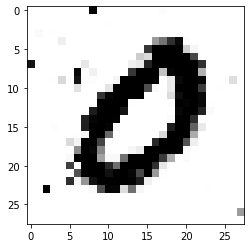

In [21]:
# Prediction Starts Here

vector = np.random.randn(100)
vector = np.expand_dims(vector, axis=0)
X = generator.predict(vector)

# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()